# Setting

In [1]:
!pip install -q pytimekr
!pip install -q rdkit

!pip install catboost
!pip install xgboost
!pip install lightgbm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 49.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append('./drive/MyDrive/Storage/Github/hyuckjinkim/lib-python')

from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

# import sys
# sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [4]:
import os
os.chdir('./drive/MyDrive/Storage/Github/hyuckjinkim/data-scientist-competitions/Dacon/17_신약개발경진대회/')
# os.chdir('../')

In [5]:
gc_collect_all()

In [6]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [7]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [8]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [9]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

<br></br>

# Configuration

In [10]:
class CFG:
    TARGET = ['MLM','HLM']
    SEGMENT = None
    SUBSET_DEPTH = 2

    # transform
    TARGET_TRANSFORMATION = 'identity'

    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Chemical Data
- 참조 : [Dacon](https://dacon.io/competitions/official/236127/codeshare/8812?page=1&dtype=recent)

In [ ]:
# !pip install mendeleev
# !pip install rdkit
# !pip install torch_geometric
# !pip install transformers
# !pip install deepchem
# !pip install pytorch_lightning
# !pip install sqlalchemy==1.4.49

In [ ]:
import sqlalchemy
sqlalchemy.__version__

'1.4.49'

In [ ]:
from mendeleev.fetch import fetch_table
from rdkit import Chem
from rdkit.Chem import (Descriptors,
                        Lipinski,
                        Crippen,
                        rdMolDescriptors,
                        MolFromSmiles,
                        AllChem,
                        PandasTools)

from torch import Tensor
from torch_geometric.utils.sparse import dense_to_sparse

from transformers import AutoTokenizer, AutoModel

import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from rdkit import DataStructs
from deepchem import feat

archieve = ['seyonec/PubChem10M_SMILES_BPE_450k', "DeepChem/ChemBERTa-77M-MTR", 'seyonec/ChemBERTa-zinc-base-v1', 'seyonec/ChemBERTa_zinc250k_v2_40k']
chosen = archieve[2]

class Chemical_feature_generator():
    def __init__(self) -> None:
        mendeleev_atomic_f = ['atomic_radius', 'atomic_radius_rahm', 'atomic_volume', 'atomic_weight', 'c6', 'c6_gb',
                        'covalent_radius_cordero', 'covalent_radius_pyykko', 'covalent_radius_pyykko_double', 'covalent_radius_pyykko_triple',
                        'density', 'dipole_polarizability', 'dipole_polarizability_unc', 'electron_affinity', 'en_allen', 'en_ghosh', 'en_pauling',
                        'heat_of_formation', 'is_radioactive', 'molar_heat_capacity', 'specific_heat_capacity', 'vdw_radius']
                        # Others are fine
                        # Heat of Formation: This reflects the energy associated with the formation of a molecule and might indirectly impact metabolic reactions.
                        # Is Radioactive: This binary property may not be directly relevant to metabolic stability.
                        # Molar Heat Capacity, Specific Heat Capacity: These properties relate to heat transfer but might not be directly tied to metabolic stability.
        self.mendeleev_atomic_f_table = fetch_table('elements')[mendeleev_atomic_f]

        self.DMPNNFeaturizer = feat.DMPNNFeaturizer()
        self.Mol2VecFingerprint = feat.Mol2VecFingerprint()
        self.BPSymmetryFunctionInput = feat.BPSymmetryFunctionInput(max_atoms=150)

        self.tokenizer = AutoTokenizer.from_pretrained(chosen)

        # train_atom_idx = [5, 7, 6, 15, 8, 16, 34, 33, 52] # test idx = [5, 6, 15, 7, 16, 34, 8, 14]
        # train_table = self.mendeleev_atomic_f_table.loc[train_atom_idx]
        # scaler = StandardScaler()
        # scaler.fit(train_table)

        # self.mendeleev_atomic_f_table.iloc[:, :] = scaler.transform(self.mendeleev_atomic_f_table)

    def get_atomic_features(self,atom):

        atomic_num = atom.GetAtomicNum() - 1 # -1 is offset
        mendel_atom_f = self.mendeleev_atomic_f_table.loc[atomic_num]
        # mendel_atom_f.is_radioactive = mendel_atom_f.is_radioactive.astype(int)
        mendel_atom_f = mendel_atom_f.to_numpy().astype(np.float32)

        rdkit_atom_f = [atom.GetDegree(),
                atom.GetTotalDegree(),
                atom.GetFormalCharge(),
                atom.GetIsAromatic()*1.,
                atom.GetNumImplicitHs(),
                atom.GetNumExplicitHs(),
                atom.GetTotalNumHs(),
                atom.GetNumRadicalElectrons(),
                atom.GetImplicitValence(),
                atom.GetExplicitValence(),
                atom.GetTotalValence(),
                atom.IsInRing()*1.]

        return mendel_atom_f, rdkit_atom_f

    def get_molecular_features(self, mol):
        ## 1. Molecular Descriptors 5
        MolWt = Descriptors.MolWt(mol)
        HeavyAtomMolWt = Descriptors.HeavyAtomMolWt(mol)
        NumValenceElectrons = Descriptors.NumValenceElectrons(mol)
        MolMR = Crippen.MolMR(mol)
        MolLogP = Crippen.MolLogP(mol)

        ## 2. Lipinski's Rule of Five 16
        FractionCSP3 = Lipinski.FractionCSP3(mol)
        HeavyAtomCount = Lipinski.HeavyAtomCount(mol)
        NHOHCount = Lipinski.NHOHCount(mol)
        NOCount = Lipinski.NOCount(mol)
        NumAliphaticCarbocycles = Lipinski.NumAliphaticCarbocycles(mol)
        NumAliphaticHeterocycles = Lipinski.NumAliphaticHeterocycles(mol)
        NumAliphaticRings = Lipinski.NumAliphaticRings(mol)
        NumAromaticCarbocycles = Lipinski.NumAromaticCarbocycles(mol)
        NumAromaticHeterocycles = Lipinski.NumAromaticHeterocycles(mol)
        NumAromaticRings = Lipinski.NumAromaticRings(mol)
        NumHAcceptors = Lipinski.NumHAcceptors(mol)
        NumHDonors = Lipinski.NumHDonors(mol)
        NumHeteroatoms = Lipinski.NumHeteroatoms(mol)
        NumRotatableBonds = Lipinski.NumRotatableBonds(mol)
        RingCount = Lipinski.RingCount(mol)
        CalcNumBridgeheadAtom = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)

        ## 3. Additional Features 11
        ExactMolWt = Descriptors.ExactMolWt(mol)
        NumRadicalElectrons = Descriptors.NumRadicalElectrons(mol)
        # MaxPartialCharge = Descriptors.MaxPartialCharge(mol)
        # MinPartialCharge = Descriptors.MinPartialCharge(mol)
        # MaxAbsPartialCharge = Descriptors.MaxAbsPartialCharge(mol)
        # MinAbsPartialCharge = Descriptors.MinAbsPartialCharge(mol)
        NumSaturatedCarbocycles = Lipinski.NumSaturatedCarbocycles(mol)
        NumSaturatedHeterocycles = Lipinski.NumSaturatedHeterocycles(mol)
        NumSaturatedRings = Lipinski.NumSaturatedRings(mol)
        CalcNumAmideBonds = rdMolDescriptors.CalcNumAmideBonds(mol)
        CalcNumSpiroAtoms = rdMolDescriptors.CalcNumSpiroAtoms(mol)

        num_carboxyl_groups = len(mol.GetSubstructMatches(MolFromSmiles("[C](=O)[OH]"))) # "[C;X3](=O)[OH1]" not working
        num_amion_groups = len(mol.GetSubstructMatches(MolFromSmiles("[NH2]")))
        num_ammonium_groups = len(mol.GetSubstructMatches(MolFromSmiles("[NH4+]")))
        num_sulfonic_acid_groups = len(mol.GetSubstructMatches(MolFromSmiles("[S](=O)(=O)[O-]")))
        num_alkoxy_groups = len(mol.GetSubstructMatches(MolFromSmiles('CO'))) # "[*]-O-[*]" not working

        return [MolWt,
                HeavyAtomMolWt,
                NumValenceElectrons,
                FractionCSP3,
                HeavyAtomCount,
                NHOHCount,
                NOCount,
                NumAliphaticCarbocycles,
                NumAliphaticHeterocycles,
                NumAliphaticRings,
                NumAromaticCarbocycles,
                NumAromaticHeterocycles,
                NumAromaticRings,
                NumHAcceptors,
                NumHDonors,
                NumHeteroatoms,
                NumRotatableBonds,
                RingCount,
                MolMR,
                CalcNumBridgeheadAtom,
                ExactMolWt,
                NumRadicalElectrons,
                # MaxPartialCharge,
                # MinPartialCharge,
                # MaxAbsPartialCharge,
                # MinAbsPartialCharge,
                NumSaturatedCarbocycles,
                NumSaturatedHeterocycles,
                NumSaturatedRings,
                MolLogP,
                CalcNumAmideBonds,
                CalcNumSpiroAtoms,
                num_carboxyl_groups,
                num_amion_groups,
                num_ammonium_groups,
                num_sulfonic_acid_groups,
                num_alkoxy_groups]

    def get_molecule_fingerprints(self, mol):
        ECFP12 = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=2048) # 2048
        ECFP6 = AllChem.GetHashedMorganFingerprint(mol, 3, nBits=2048) # 2048

        MACCS = Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol) # 167
        RDK_fp = Chem.RDKFingerprint(mol) # 2048
        Layer_fp = Chem.rdmolops.LayeredFingerprint(mol) # 2048
        Pattern_fp = Chem.rdmolops.PatternFingerprint(mol) # 2048

        ecfp12 = np.zeros((1,), dtype=np.int8)
        ecfp6 = np.zeros((1,), dtype=np.int8)
        maccs = np.zeros((1,), dtype=np.int8)
        rdk_fp = np.zeros((1,), dtype=np.int8)
        layer_fp = np.zeros((1,), dtype=np.int8)
        pattern_fp = np.zeros((1,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(ECFP12, ecfp12)
        DataStructs.ConvertToNumpyArray(ECFP6, ecfp6)
        DataStructs.ConvertToNumpyArray(MACCS, maccs)
        DataStructs.ConvertToNumpyArray(RDK_fp, rdk_fp)
        DataStructs.ConvertToNumpyArray(Layer_fp, layer_fp)
        DataStructs.ConvertToNumpyArray(Pattern_fp, pattern_fp)
        return np.hstack([ecfp12, ecfp6, maccs, rdk_fp, layer_fp, pattern_fp])

    def get_mol_feature_from_deepchem(self, smiles):
        return self.Mol2VecFingerprint(smiles) # (1, 300)

    def encoder_smiles(self, smiles):
        inputs = self.tokenizer.encode_plus(smiles, padding=True, return_tensors='pt', add_special_tokens=True)
        # outputs = self.model()
        return inputs['input_ids']

    def get_atomic_feature_from_deepchem(self, smiles):
        # CCCC(=O)OC[C@@H](OC(=O)CCC)[C@@H](OC(=O)CCC)[C@H](Cn1c2nc(=O)[nH]c(=O)c-2nc2cc(C)c(C)cc21)OC(=O)CCC
        # 이런거 때문에 죽게되는 경우가 발생
        # BPSF_matrix = self.BPSymmetryFunctionInput(smiles)[0] # 100 x 4
        DMPNN_F = self.DMPNNFeaturizer(smiles)[0].node_features

        # atom_n, _ = DMPNN_F.shape
        # try:
        #     np.concatenate([DMPNN_F, BPSF_matrix[:atom_n, :]], axis=1, dtype=np.float32)
        # except:
        #     print(BPSF_matrix.shape, DMPNN_F.shape)
        #     # np.concatenate([DMPNN_F, BPSF_matrix[:atom_n, :]], axis=1, dtype=np.float32)
        #     print(Exception)
        #     exit()
        return DMPNN_F

    def generate_mol_atomic_features(self, smiles):

        mol = Chem.MolFromSmiles(smiles)

        # gathering atomic feature
        mendel_atom_features = []
        rdkit_atom_features = []
        for atom in mol.GetAtoms():
            mendel_atom_f, rdkit_atom_f = self.get_atomic_features(atom)

            mendel_atom_features.append(mendel_atom_f)
            rdkit_atom_features.append(rdkit_atom_f)

        dc_atmoic = self.get_atomic_feature_from_deepchem(smiles)
        atomic_features = np.concatenate([mendel_atom_features, rdkit_atom_features, dc_atmoic], axis=1, dtype=np.float32)

        return atomic_features

    def get_adj_matrix(self, smiles):

        mol = MolFromSmiles(smiles)
        adj = Chem.rdmolops.GetAdjacencyMatrix(mol)

        edge_index, edge_attr = dense_to_sparse(Tensor(adj))

        # bonds = []
        # for i in range(0, mol.GetNumAtoms()):
        #     for j in range(0, mol.GetNumAtoms()):
        #         if adj[i, j] == 1:
        #             bonds.append([i, j])

        return edge_index, edge_attr

In [ ]:
def process(df):
    molecular_f = []
    for sample in tqdm(df.SMILES):
        sample = Chem.MolFromSmiles(sample)
        molecular_features = generator.get_molecular_features(mol=sample)
        # print(fps.shape)
        molecular_f.append(molecular_features)

        # for fp, name in zip(fps, ['ECFP12','ECFP6','MACCS','RDK_fp','Layer_fp','Pattern_fp']):
        #     print(name, len(fp))
    molecular_f = np.concatenate([molecular_f], axis=0)
    # print(molecular_f.shape)

    return pd.DataFrame(data=molecular_f, columns=['MolWt','HeavyAtomMolWt','NumValenceElectrons','FractionCSP3','HeavyAtomCount','NHOHCount','NOCount','NumAliphaticCarbocycles','NumAliphaticHeterocycles','NumAliphaticRings','NumAromaticCarbocycles','NumAromaticHeterocycles','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','RingCount','MolMR','CalcNumBridgeheadAtom','ExactMolWt','NumRadicalElectrons','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','MolLogP','CalcNumAmideBonds','CalcNumSpiroAtoms','num_carboxyl_groups','num_amion_groups','num_ammonium_groups','num_sulfonic_acid_groups','num_alkoxy_groups',])
                                                #    'ECFP12','ECFP6','MACCS','RDK_fp','Layer_fp','Pattern_fp' ])

def deepchem_rdkit(df):

    featurizer = RDKitDescriptors()
    rdkit_features = []

    for smiles in tqdm(df.SMILES):
        feature = featurizer(smiles)
        rdkit_features.append(feature)

    return np.concatenate(rdkit_features)

In [ ]:
import pandas as pd
from tqdm import tqdm
from deepchem.feat.molecule_featurizers import RDKitDescriptors

train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

generator = Chemical_feature_generator()

# print(train.iloc[1, :])
# print(test.columns)
# train_molecular_f = process(train)
# train_merged = pd.concat([train, train_molecular_f], axis=1)

# test_molecular_f = process(test)
# test_merged = pd.concat([test, test_molecular_f], axis=1)

# train_merged.to_csv('/root/Competitions/DACON/4. JUMP AI 2023/data/new_train.csv', index=False)
# test_merged.to_csv('/root/Competitions/DACON/4. JUMP AI 2023/data/new_test.csv', index=False)

In [ ]:
features = deepchem_rdkit(train)
column_means = np.mean(features, axis=0)
non_zero_mean_columns = np.where(column_means != 0)[0]
features = features[:, non_zero_mean_columns]
features = np.concatenate([np.array(train.SMILES).reshape(-1,1),features],axis=1)
features = pd.DataFrame(features).dropna(axis=1)
pd.DataFrame(features).to_csv('./out/rdkit_train.csv', index=False)
train_col = features.columns

features = deepchem_rdkit(test)
features = features[:, non_zero_mean_columns]
features = np.concatenate([np.array(test.SMILES).reshape(-1,1),features],axis=1)
features = pd.DataFrame(features).dropna(axis=1)
features = features[train_col]
pd.DataFrame(features).to_csv('./out/rdkit_test.csv', index=False)
test_col = features.columns

<br></br>

# Data Load

In [11]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [12]:
train_rdkit_features = pd.read_csv('./out/rdkit_train.csv')
test_rdkit_features  = pd.read_csv('./out/rdkit_test.csv')
rename_cols = ['SMILES' if col=='0' else f'rdkit{col}' for col in train_rdkit_features.columns]

train_rdkit_features.columns = rename_cols
test_rdkit_features.columns  = rename_cols

train_df = pd.merge(train_df,train_rdkit_features,how='left',on='SMILES')
test_df  = pd.merge(test_df ,test_rdkit_features ,how='left',on='SMILES')

In [13]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,rdkit1,rdkit2,rdkit3,rdkit4,rdkit5,rdkit6,rdkit7,rdkit8,rdkit9,rdkit14,rdkit15,rdkit16,rdkit25,rdkit26,rdkit27,rdkit28,rdkit29,rdkit30,rdkit31,rdkit32,rdkit33,rdkit34,rdkit35,rdkit36,rdkit37,rdkit38,rdkit39,rdkit40,rdkit41,rdkit42,rdkit43,rdkit44,rdkit45,rdkit46,rdkit47,rdkit48,rdkit49,rdkit50,rdkit51,rdkit52,rdkit53,rdkit54,rdkit55,rdkit56,rdkit57,rdkit58,rdkit59,rdkit60,rdkit61,rdkit62,rdkit63,rdkit64,rdkit65,rdkit66,rdkit67,rdkit68,rdkit69,rdkit70,rdkit71,rdkit72,rdkit73,rdkit74,rdkit75,rdkit76,rdkit77,rdkit78,rdkit79,rdkit80,rdkit81,rdkit82,rdkit83,rdkit84,rdkit85,rdkit86,rdkit87,rdkit88,rdkit89,rdkit90,rdkit91,rdkit92,rdkit93,rdkit94,rdkit95,rdkit96,rdkit97,rdkit98,rdkit99,rdkit100,rdkit101,rdkit102,rdkit103,rdkit104,rdkit105,rdkit106,rdkit107,rdkit108,rdkit109,rdkit110,rdkit111,rdkit112,rdkit113,rdkit114,rdkit115,rdkit116,rdkit117,rdkit118,rdkit119,rdkit120,rdkit121,rdkit122,rdkit123,rdkit124,rdkit125,rdkit126,rdkit127,rdkit128,rdkit129,rdkit130,rdkit131,rdkit132,rdkit133,rdkit134,rdkit135,rdkit136,rdkit137,rdkit138,rdkit139,rdkit140,rdkit141,rdkit142,rdkit143,rdkit144,rdkit145,rdkit146,rdkit147,rdkit148,rdkit149,rdkit150,rdkit151,rdkit152,rdkit153,rdkit154,rdkit155,rdkit156,rdkit157,rdkit158,rdkit159,rdkit160,rdkit161,rdkit162,rdkit163,rdkit164,rdkit165,rdkit166,rdkit167,rdkit168,rdkit169,rdkit170,rdkit171,rdkit172,rdkit173,rdkit174,rdkit175,rdkit176,rdkit177,rdkit178,rdkit179,rdkit180,rdkit181,rdkit182,rdkit183,rdkit184,rdkit185,rdkit186,rdkit187,rdkit188,rdkit189,rdkit190,rdkit191
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,12.482330,12.482330,0.218070,-0.218070,0.598984,400.504,376.312,400.156912,148.0,1.142857,1.892857,2.571429,3.278735,1.672477,964.269059,20.095647,16.458142,17.274638,13.511570,9.179103,9.995599,6.144068,7.347263,4.019527,5.114899,2.806363,3.686836,-2.87,3.278735,19.879596,8.879223,4.507576,167.660876,14.790515,11.387856,11.499024,0.000000,5.90718,0.0,9.893219,4.983979,5.098682,11.336786,6.066367,51.457501,6.544756,28.792463,14.268263,17.243966,0.0,20.498131,0.000000,34.239705,13.213764,46.224399,22.070099,14.790515,0.000000,11.499024,11.336786,34.302286,6.544756,13.847474,40.600943,24.265468,0.0,10.571075,89.13,0.000000,4.794537,0.0,5.907180,36.951472,26.836078,0.000000,17.403153,45.894050,20.498131,9.473726,11.194365,1.563124,17.858256,10.937746,2.983415,1.160470,7.407277,0.000000,9.228682,0.000000,0.350000,28.0,2.0,7.0,0.0,0.0,0.0,1.0,2.0,3.0,6.0,2.0,8.0,8.0,0.0,0.0,0.0,3.0,3.87744,109.1199,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,12.098337,12.098337,0.035440,-0.035440,0.924896,301.415,282.263,301.124883,110.0,1.380952,2.142857,2.857143,2.697499,1.963084,679.911654,14.982763,12.511889,13.328385,10.041714,7.120826,7.937322,5.529440,6.817186,3.778503,4.836111,2.666114,3.619017,-1.88,2.697499,14.073964,5.483862,2.784723,128.368490,10.216698,0.000000,0.000000,5.907180,0.00000,0.0,4.794537,4.983979,0.000000,11.336786,19.056471,25.980209,11.421904,34.538987,4.794537,28.618738,0.0,4.983979,5.917906,27.315968,16.761455,39.844167,0.000000,10.216698,11.374773,0.000000,11.336786,17.435915,11.339294,19.765380,22.502436,24.265468,0.0,0.000000,45.23,0.000000,4.794537,0.0,11.825086,0.000000,35.165837,4.877147,11.336786,32.046576,28.190781,0.000000,0.000000,1.733388,20.140677,4.105507,3.067185,0.049890,7.994110,0.000000,7.575909,0.000000,0.375000,21.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,5.0,2.0,0.0,0.0,0.0,3.0,3.35474,86.8737,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0

<br></br>

# EDA

In [14]:
# train_df.describe().round(2)

In [15]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [16]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [17]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [18]:
# train_df.nunique()

In [19]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]

#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

<br></br>

# Data Preprocess

In [20]:
for col in ['Molecular_Weight','Molecular_PolarSurfaceArea']:
    train_df[col] = np.log(train_df[col])
    test_df [col] = np.log(test_df [col])

- [Dacon](https://dacon.io/competitions/official/236127/talkboard/409051?page=1&dtype=recent)에 따르면 100이 넘는 값도 나올 수 있음

In [21]:
# targets = ['MLM','HLM']
# for t in targets:
#     train_df[t] = [0 if x<0 else
#                    100 if x>100 else
#                    x for x in train_df[t]]

<br>

In [22]:
# 사용할 column만 추출
unuse_features = ['id','SMILES']
num_features = [col for col in train_df.columns if col not in unuse_features+CFG.TARGET]

train_df.drop(unuse_features,axis=1,inplace=True)
test_df .drop(unuse_features,axis=1,inplace=True)

In [23]:
train_df.shape

(3552, 188)

In [24]:
train_df.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,rdkit1,rdkit2,rdkit3,rdkit4,rdkit5,rdkit6,rdkit7,rdkit8,rdkit9,rdkit14,rdkit15,rdkit16,rdkit25,rdkit26,rdkit27,rdkit28,rdkit29,rdkit30,rdkit31,rdkit32,rdkit33,rdkit34,rdkit35,rdkit36,rdkit37,rdkit38,rdkit39,rdkit40,rdkit41,rdkit42,rdkit43,rdkit44,rdkit45,rdkit46,rdkit47,rdkit48,rdkit49,rdkit50,rdkit51,rdkit52,rdkit53,rdkit54,rdkit55,rdkit56,rdkit57,rdkit58,rdkit59,rdkit60,rdkit61,rdkit62,rdkit63,rdkit64,rdkit65,rdkit66,rdkit67,rdkit68,rdkit69,rdkit70,rdkit71,rdkit72,rdkit73,rdkit74,rdkit75,rdkit76,rdkit77,rdkit78,rdkit79,rdkit80,rdkit81,rdkit82,rdkit83,rdkit84,rdkit85,rdkit86,rdkit87,rdkit88,rdkit89,rdkit90,rdkit91,rdkit92,rdkit93,rdkit94,rdkit95,rdkit96,rdkit97,rdkit98,rdkit99,rdkit100,rdkit101,rdkit102,rdkit103,rdkit104,rdkit105,rdkit106,rdkit107,rdkit108,rdkit109,rdkit110,rdkit111,rdkit112,rdkit113,rdkit114,rdkit115,rdkit116,rdkit117,rdkit118,rdkit119,rdkit120,rdkit121,rdkit122,rdkit123,rdkit124,rdkit125,rdkit126,rdkit127,rdkit128,rdkit129,rdkit130,rdkit131,rdkit132,rdkit133,rdkit134,rdkit135,rdkit136,rdkit137,rdkit138,rdkit139,rdkit140,rdkit141,rdkit142,rdkit143,rdkit144,rdkit145,rdkit146,rdkit147,rdkit148,rdkit149,rdkit150,rdkit151,rdkit152,rdkit153,rdkit154,rdkit155,rdkit156,rdkit157,rdkit158,rdkit159,rdkit160,rdkit161,rdkit162,rdkit163,rdkit164,rdkit165,rdkit166,rdkit167,rdkit168,rdkit169,rdkit170,rdkit171,rdkit172,rdkit173,rdkit174,rdkit175,rdkit176,rdkit177,rdkit178,rdkit179,rdkit180,rdkit181,rdkit182,rdkit183,rdkit184,rdkit185,rdkit186,rdkit187,rdkit188,rdkit189,rdkit190,rdkit191
0,26.010,50.680,3.259,5.992701,5,2,8,3.259,4.765331,12.482330,12.482330,0.218070,-0.218070,0.598984,400.504,376.312,400.156912,148.0,1.142857,1.892857,2.571429,3.278735,1.672477,964.269059,20.095647,16.458142,17.274638,13.511570,9.179103,9.995599,6.144068,7.347263,4.019527,5.114899,2.806363,3.686836,-2.87,3.278735,19.879596,8.879223,4.507576,167.660876,14.790515,11.387856,11.499024,0.000000,5.90718,0.0,9.893219,4.983979,5.098682,11.336786,6.066367,51.457501,6.544756,28.792463,14.268263,17.243966,0.0,20.498131,0.000000,34.239705,13.213764,46.224399,22.070099,14.790515,0.000000,11.499024,11.336786,34.302286,6.544756,13.847474,40.600943,24.265468,0.0,10.571075,89.13,0.000000,4.794537,0.0,5.907180,36.951472,26.836078,0.000000,17.403153,45.894050,20.498131,9.473726,11.194365,1.563124,17.858256,10.937746,2.983415,1.160470,7.407277,0.000000,9.228682,0.000000,0.350000,28.0,2.0,7.0,0.0,0.0,0.0,1.0,2.0,3.0,6.0,2.0,8.0,8.0,0.0,0.0,0.0,3.0,3.87744,109.1199,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,29.270,50.590,2.169,5.708462,2,1,2,2.172,4.296877,12.098337,12.098337,0.035440,-0.035440,0.924896,301.415,282.263,301.124883,110.0,1.380952,2.142857,2.857143,2.697499,1.963084,679.911654,14.982763,12.511889,13.328385,10.041714,7.120826,7.937322,5.529440,6.817186,3.778503,4.836111,2.666114,3.619017,-1.88,2.697499,14.073964,5.483862,2.784723,128.368490,10.216698,0.000000,0.000000,5.907180,0.00000,0.0,4.794537,4.983979,0.000000,11.336786,19.056471,25.980209,11.421904,34.538987,4.794537,28.618738,0.0,4.983979,5.917906,27.315968,16.761455,39.844167,0.000000,10.216698,11.374773,0.000000,11.336786,17.435915,11.339294,19.765380,22.502436,24.265468,0.0,0.000000,45.23,0.000000,4.794537,0.0,11.825086,0.000000,35.165837,4.877147,11.336786,32.046576,28.190781,0.000000,0.000000,1.733388,20.140677,4.105507,3.067185,0.049890,7.994110,0.000000,7.575909,0.000000,0.375000,21.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,5.0,2.0,0.0,0.0,0.0,3.0,3.35474,86.8737,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [25]:
test_df.head()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,rdkit1,rdkit2,rdkit3,rdkit4,rdkit5,rdkit6,rdkit7,rdkit8,rdkit9,rdkit14,rdkit15,rdkit16,rdkit25,rdkit26,rdkit27,rdkit28,rdkit29,rdkit30,rdkit31,rdkit32,rdkit33,rdkit34,rdkit35,rdkit36,rdkit37,rdkit38,rdkit39,rdkit40,rdkit41,rdkit42,rdkit43,rdkit44,rdkit45,rdkit46,rdkit47,rdkit48,rdkit49,rdkit50,rdkit51,rdkit52,rdkit53,rdkit54,rdkit55,rdkit56,rdkit57,rdkit58,rdkit59,rdkit60,rdkit61,rdkit62,rdkit63,rdkit64,rdkit65,rdkit66,rdkit67,rdkit68,rdkit69,rdkit70,rdkit71,rdkit72,rdkit73,rdkit74,rdkit75,rdkit76,rdkit77,rdkit78,rdkit79,rdkit80,rdkit81,rdkit82,rdkit83,rdkit84,rdkit85,rdkit86,rdkit87,rdkit88,rdkit89,rdkit90,rdkit91,rdkit92,rdkit93,rdkit94,rdkit95,rdkit96,rdkit97,rdkit98,rdkit99,rdkit100,rdkit101,rdkit102,rdkit103,rdkit104,rdkit105,rdkit106,rdkit107,rdkit108,rdkit109,rdkit110,rdkit111,rdkit112,rdkit113,rdkit114,rdkit115,rdkit116,rdkit117,rdkit118,rdkit119,rdkit120,rdkit121,rdkit122,rdkit123,rdkit124,rdkit125,rdkit126,rdkit127,rdkit128,rdkit129,rdkit130,rdkit131,rdkit132,rdkit133,rdkit134,rdkit135,rdkit136,rdkit137,rdkit138,rdkit139,rdkit140,rdkit141,rdkit142,rdkit143,rdkit144,rdkit145,rdkit146,rdkit147,rdkit148,rdkit149,rdkit150,rdkit151,rdkit152,rdkit153,rdkit154,rdkit155,rdkit156,rdkit157,rdkit158,rdkit159,rdkit160,rdkit161,rdkit162,rdkit163,rdkit164,rdkit165,rdkit166,rdkit167,rdkit168,rdkit169,rdkit170,rdkit171,rdkit172,rdkit173,rdkit174,rdkit175,rdkit176,rdkit177,rdkit178,rdkit179,rdkit180,rdkit181,rdkit182,rdkit183,rdkit184,rdkit185,rdkit186,rdkit187,rdkit188,rdkit189,rdkit190,rdkit191
0,2.641,5.890276,4,2,7,2.635,4.530016,9.478609,9.478609,0.203620,0.203620,0.789666,361.515,334.299,361.193631,136.0,1.360000,2.240000,2.960000,3.092586,1.683806,648.675799,17.648054,14.928409,15.744905,12.152198,8.872566,9.752219,6.702880,7.735125,4.368278,5.229427,3.185204,3.914625,-1.70,3.092586,18.101918,8.599552,4.901411,153.075510,15.323226,5.817863,0.000000,5.948339,0.000000,0.0,4.899910,4.983979,4.983979,11.336786,6.066367,37.781093,55.943580,0.000000,5.106527,23.102988,0.000000,14.867867,0.000000,38.896734,36.457850,34.653155,0.000000,10.216698,11.766202,0.000000,11.336786,58.299227,6.544756,0.000000,25.145443,29.776008,0.0,0.000000,64.52,0.000000,5.106527,0.0,6.606882,12.083682,44.366049,4.877147,11.336786,12.263211,56.444836,0.000000,0.000000,1.790735,15.189210,14.929621,0.000000,1.628784,6.829471,2.581279,8.050900,0.000000,0.555556,25.0,2.0,6.0,0.0,1.0,1.0,0.0,2.0,2.0,7.0,2.0,7.0,7.0,0.0,1.0,1.0,3.0,2.43160,103.2235,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.585,5.914581,5,0,3,0.585,4.224056,13.126514,13.126514,0.162613,-0.538005,0.824414,370.405,348.229,370.152872,142.0,1.111111,1.777778,2.407407,3.160961,1.621495,876.990238,18.855160,15.219761,15.219761,13.116922,9.051510,9.051510,6.699084,6.699084,5.126359,5.126359,3.642173,3.642173,-2.64,3.160961,17.757866,7.169917,3.355316,156.614447,19.110499,5.749512,5.787111,0.000000,11.466447,0.0,14.156174,0.000000,0.000000,0.000000,18.199101,12.132734,43.881753,25.887013,19.005126,5.907180,0.000000,9.467009,0.000000,18.628754,33.413074,58.512302,11.436898,10.296130,0.000000,5.749512,0.000000,54.574375,9.473726,0.000000,23.199632,47.389583,0.0,5.687386,70.00,5.787111,9.589074,0.0,17.215958,50.395758,0.000000,17.743264,11.096753,30.331835,0.000000,14.210589,18.219633,0.000000,27.329663,0.000000,0.814509,-0.417438,10.566661,2.837833,2.270353,1.462119,0.400000,27.0,0.0,7.0,0.0,2.0,2.0,1.0,1.0,2.0,6.0,0.0,7.0,3.0,0.0,2.0,2.0,4.0,1.82520,98.3635,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

<br>

## Imputation

In [26]:
def check_null(data):
    d = data.copy()

    null_info = d\
        .isnull().sum()\
        .reset_index()\
        .rename(columns={'index':'feature',0:'null_cnt'})

    null_info = null_info[null_info['null_cnt']!=0]
    null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df)
    null_info = null_info.sort_values('null_cnt',ascending=False).round(2)

    return null_info

In [27]:
check_null(train_df)

,feature,null_cnt,null_percentage
2,AlogP,2,0.06


In [28]:
# Imputation
tr_null_loc = train_df.AlogP.isnull()
te_null_loc = test_df .AlogP.isnull()

train_df.AlogP[tr_null_loc] = train_df.LogD[tr_null_loc]
test_df .AlogP[te_null_loc] = test_df .LogD[te_null_loc]

In [29]:
check_null(train_df)

,feature,null_cnt,null_percentage


<br>

## Numerical Quantile Group

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
cols = [col for col in num_features if col.find('rdkit')<0]
quantile_list = np.arange(0.0,1.1,0.1)
display(quantile_list)

for col in cols:
    col_name = '{}_quantile{}_grp'.format(col,len(quantile_list))
    quantile_values = train_df[col].quantile(quantile_list).values
    quantile_values[0] = -np.inf
    quantile_values[-1] = np.inf

    try:
        le = LabelEncoder()
        tr_grp = pd.cut(train_df[col],quantile_values)
        te_grp = pd.cut(test_df [col],quantile_values)
        train_df[col_name] = le.fit_transform(tr_grp)
        test_df [col_name] = le.transform(te_grp)
        if (train_df[col_name].isnull().sum()>0) | (test_df[col_name].isnull().sum()>0):
            raise ValueError('NaN exists')
    except:
        print('Failed: {}'.format(col))

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Failed: Num_H_Acceptors
Failed: Num_H_Donors
Failed: Num_RotatableBonds


<br>

## Target Transformation

(1) simple transformation (identity / log / sqrt)

In [32]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
train_df[CFG.TARGET] = target_transform.fit_transform(
    target=train_df[CFG.TARGET],
)

In [33]:
inverse_transform = target_transform.inverse_transform

(2) boxcox transformation → nan발생함

In [34]:
# from scipy.special import boxcox, inv_boxcox

# def boxcox_transform(x,lam=0.25):
#     return boxcox(x,lam)

# def inverse_boxcox_transform(x,lam=0.25):
#     return inv_boxcox(x,lam)

In [35]:
# inverse_transform = inverse_boxcox_transform

In [36]:
# y = train_df['HLM'].copy()
# y = boxcox_transform(y,0.45)

# print(y.isnull().sum())

# plt.figure(figsize=(15,7))
# plt.hist(y,bins=50)
# plt.grid()
# plt.show()

In [37]:
# for col in CFG.TARGET:
#     train_df[col] = boxcox_transform(train_df[col])

In [38]:
# train_df[CFG.TARGET].isnull().sum()

In [39]:
# inverse_transform(train_df[CFG.TARGET]).isnull().sum()

(3) quantile transformer

In [40]:
# from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer()
# scaled = scaler.fit_transform(train_df[CFG.TARGET])

In [41]:
# inverse_transform = scaler.inverse_transform

In [42]:
# # asis
# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(train_df['MLM'],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(train_df['HLM'],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Asis',fontsize=20)
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(scaled[:,0],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(scaled[:,1],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Tobe',fontsize=20)
# plt.tight_layout()
# plt.show()

In [43]:
# train_df[CFG.TARGET] = scaled

In [44]:
# train_df.head()

(4) sigmoid → nan발생함

In [45]:
# import warnings
# warnings.filterwarnings("ignore")

# from sklearn.preprocessing import MinMaxScaler

# class SigmoidTransformer:
#     def __init__(self):
#         self.minmax_scaler = MinMaxScaler(feature_range=(-5,5))

#     def _sigmoid(self,x):
#         return 1 / (1+np.exp(-x))

#     def _inv_sigmoid(self,x):
#         return -np.log(1/x-1)

#     def fit(self,x):
#         self.shape = np.array(x).shape
#         y = np.array(x).reshape(-1,self.shape[1])
#         self.minmax_scaler.fit(y)

#     def transform(self,x):
#         y = np.array(x).reshape(-1,self.shape[1])
#         y = self.minmax_scaler.transform(x)
#         y = y.reshape(-1,self.shape[1])
#         y = self._sigmoid(y)
#         return y

#     def fit_transform(self,x):
#         self.fit(x)
#         return self.transform(x)

#     def inverse_transform(self,x):
#         y = np.array(x)
#         y = self._inv_sigmoid(y)
#         y = np.array(y).reshape(-1,self.shape[1])
#         y = self.minmax_scaler.inverse_transform(y)
#         return y

In [46]:
# scaler = SigmoidTransformer()
# scaled = scaler.fit_transform(train_df[CFG.TARGET])

In [47]:
# inverse_transform = scaler.inverse_transform

In [48]:
# # asis
# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(train_df['MLM'],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(train_df['HLM'],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Asis',fontsize=20)
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(scaled[:,0],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(scaled[:,1],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Tobe',fontsize=20)
# plt.tight_layout()
# plt.show()

In [49]:
# train_df[CFG.TARGET] = scaled

(5) pca transform
- 참조 : [Kaggle](https://www.kaggle.com/code/xiafire/lb-t15-msci-multiome-catboostregressor)

In [50]:
# from sklearn.decomposition import PCA, TruncatedSVD

In [51]:
# train_targets = train_df[CFG.TARGET]

# pca_target = TruncatedSVD(n_components=2, random_state=CFG.SEED)
# train_targets = pca_target.fit_transform(train_targets)

# train_df[CFG.TARGET] = train_targets

In [52]:
# inverse_transform = pca_target.inverse_transform

In [53]:
# train_df[CFG.TARGET]@pca_target.components_

(check)

In [54]:
train_df[CFG.TARGET].head()

,MLM,HLM
0,26.010,50.680
1,29.270,50.590
2,5.586,80.892
3,5.710,2.000
4,93.270,99.990


In [55]:
train_df[CFG.TARGET].isnull().sum()

MLM    0
HLM    0
dtype: int64

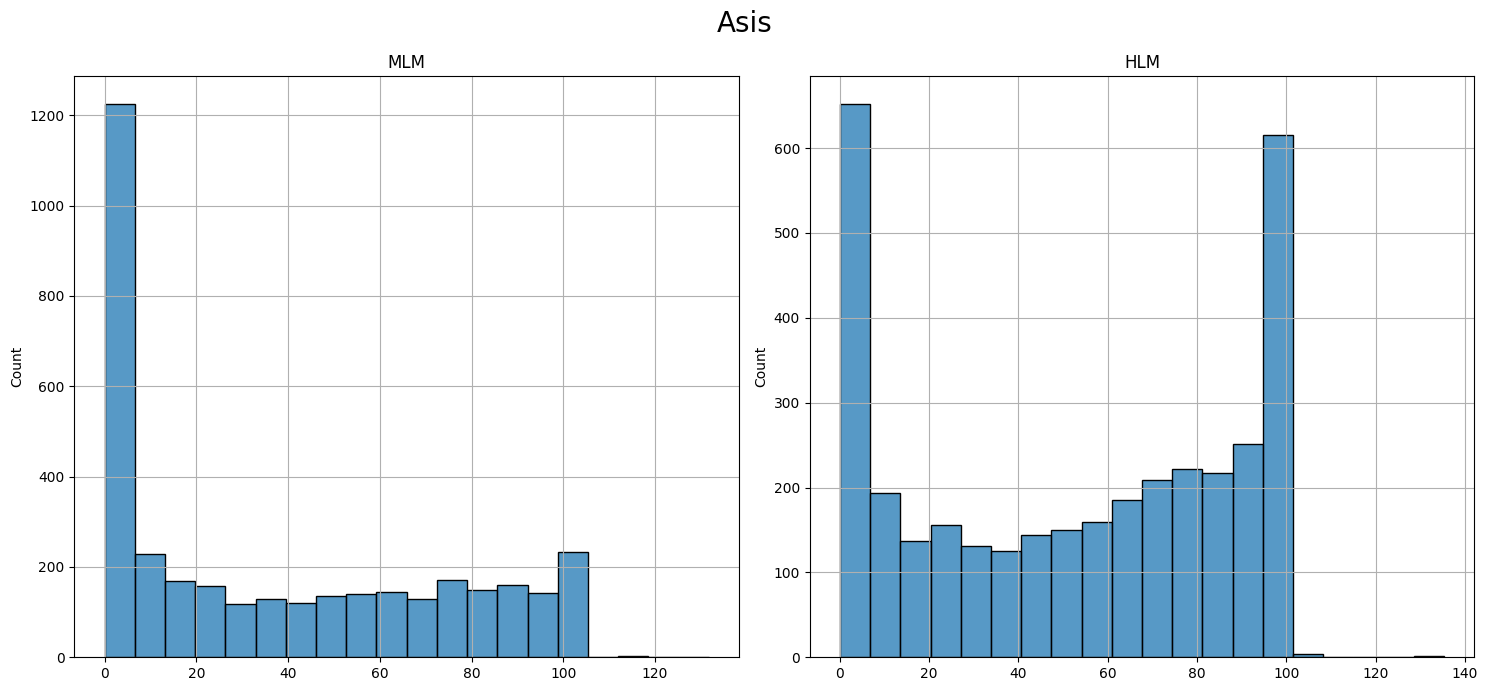

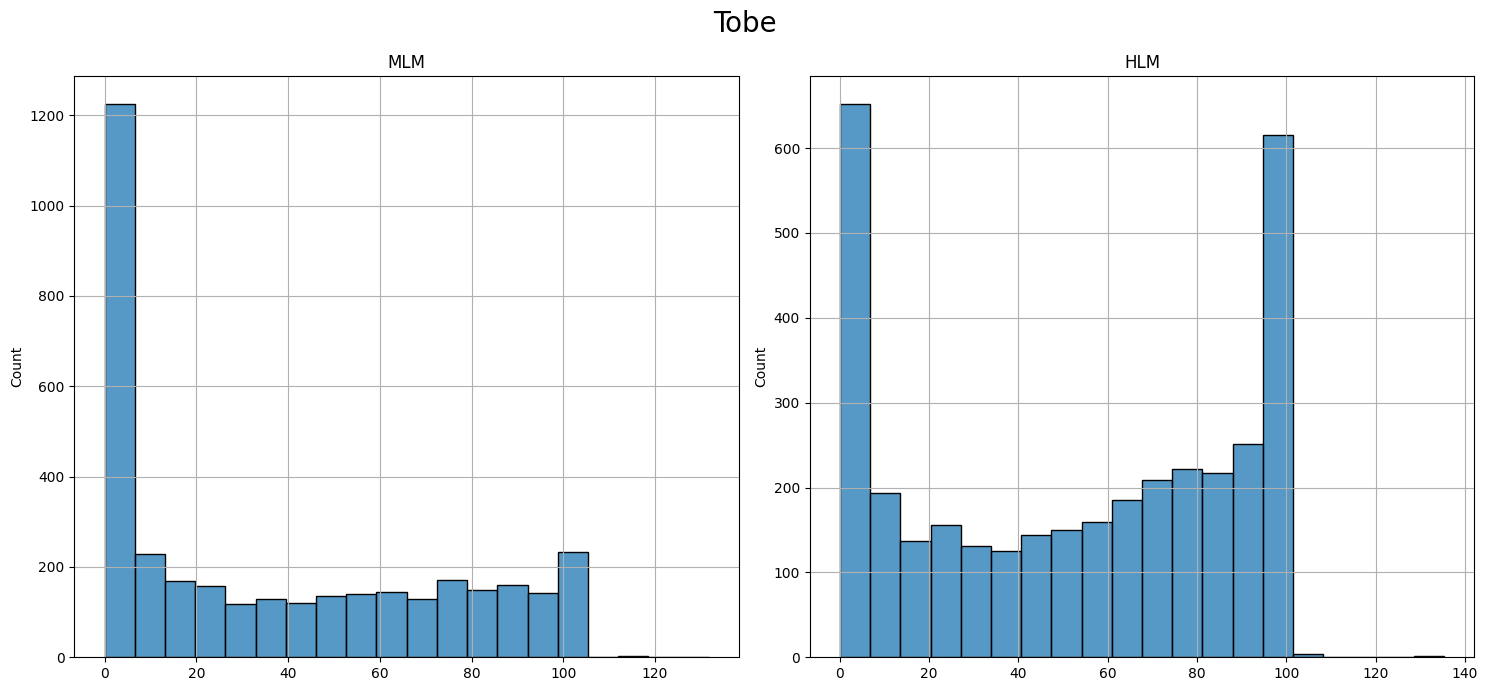

In [56]:
# Asis
ys = np.array(train_df[CFG.TARGET])
ys = inverse_transform(ys)

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.histplot(ys[:,0],bins=20)
plt.title('MLM')
plt.grid()
fig.add_subplot(122)
sns.histplot(ys[:,1],bins=20)
plt.title('HLM')
plt.grid()
plt.suptitle('Asis',fontsize=20)
plt.tight_layout()
plt.show()

# Tobe
ys = np.array(train_df[CFG.TARGET])

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.histplot(ys[:,0],bins=20)
plt.title('MLM')
plt.grid()
fig.add_subplot(122)
sns.histplot(ys[:,1],bins=20)
plt.title('HLM')
plt.grid()
plt.suptitle('Tobe',fontsize=20)
plt.tight_layout()
plt.show()

<br>

## Interaction Term

In [57]:
num_features = train_df.columns.difference(CFG.TARGET)
len(num_features)

190

In [58]:
# interaction_maker = InteractionTerm()
# interaction_maker.fit(
#     data=train_df,
#     num_features=num_features,
#     corr_cutoff=0.9,
# )
# train_df = interaction_maker.transform(train_df)
# test_df  = interaction_maker.transform(test_df)

In [59]:
# train_df.shape

In [60]:
t = 'HLM'

interaction_cols = [col for col in train_df.columns if col.find('*')>=0]
len(interaction_cols)

corr_list = []
for col in tqdm(interaction_cols):
    corr = train_df[[col,t]].corr().values[0,1]
    corr_list.append([col,np.abs(corr)])

corr_df = pd.DataFrame(corr_list,columns=['feature','abs_correlation'])\
    .sort_values('abs_correlation',ascending=False)

0it [00:00, ?it/s]


In [61]:
for col,corr in corr_df.values[:5]:
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=train_df[col],y=train_df[t])
    plt.grid()
    plt.title('{}: {:.4f}'.format(col,corr))
    plt.show()

<br>

## Categorical Taget Quantile

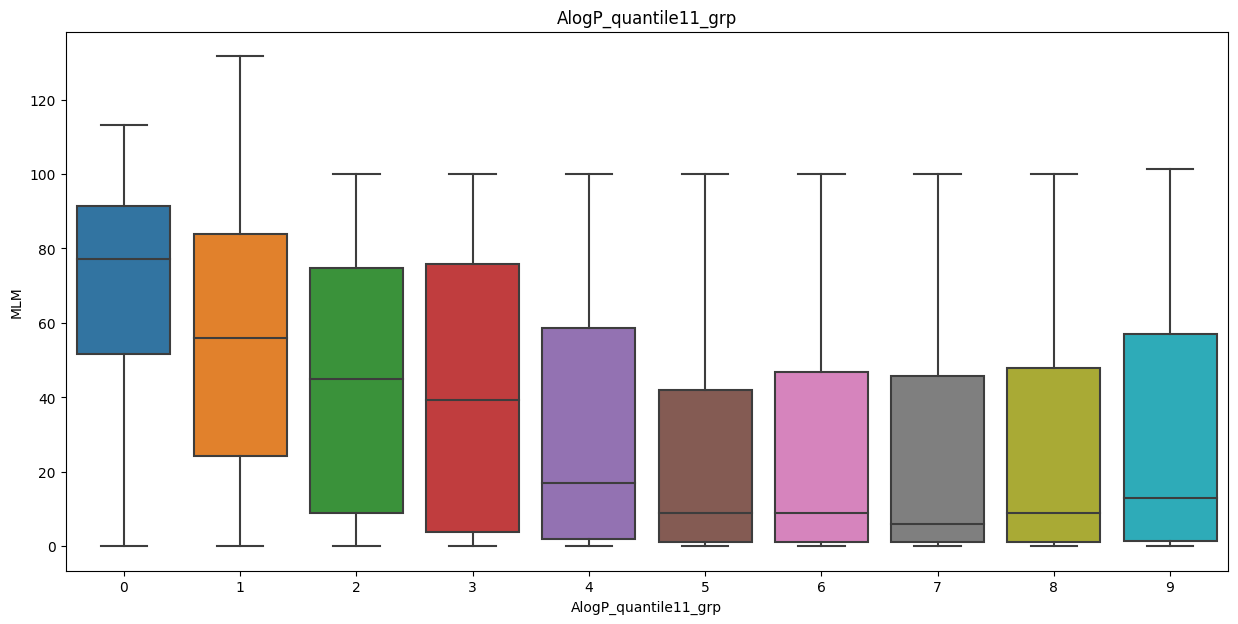

0 []


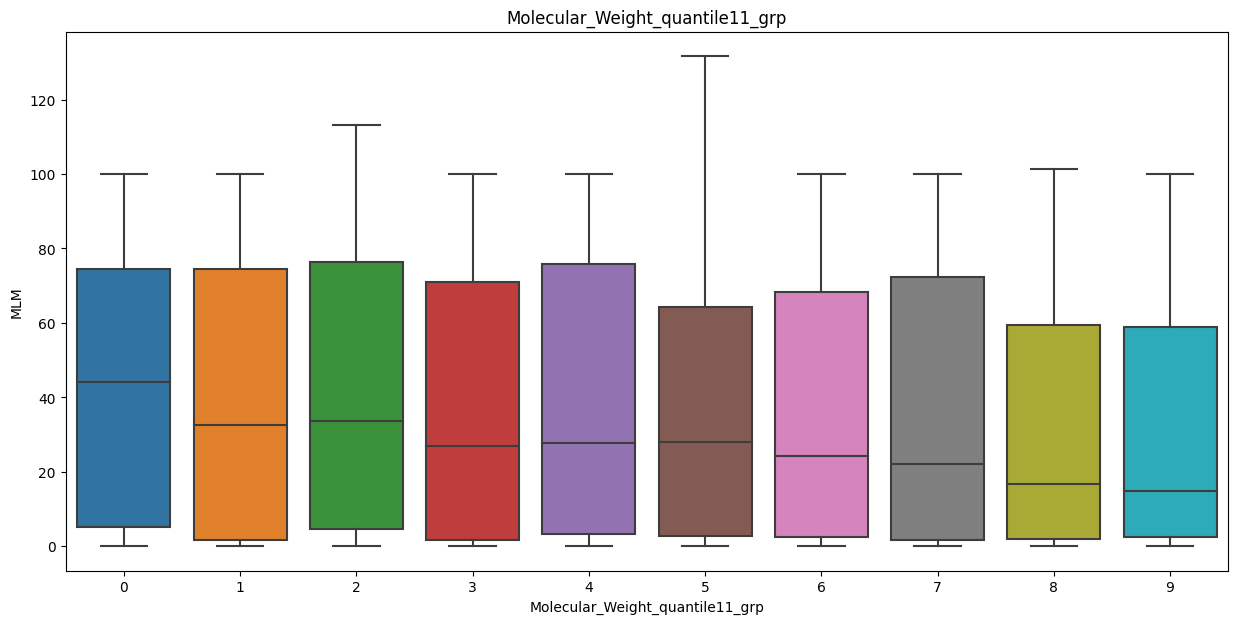

0 []


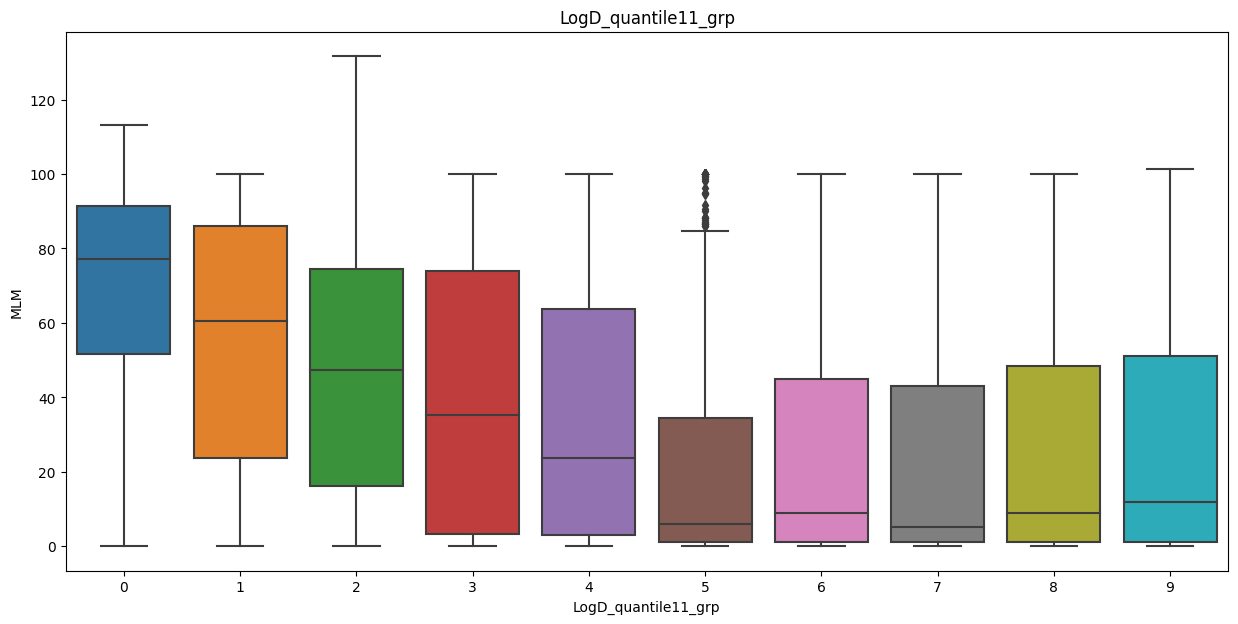

0 []


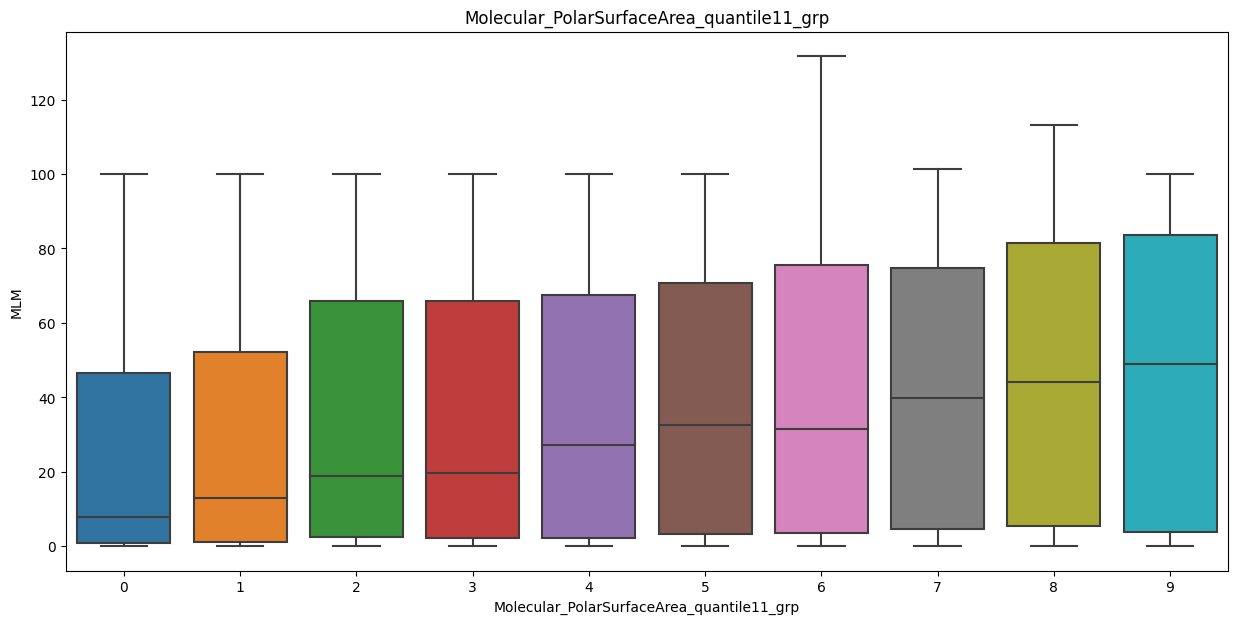

0 []


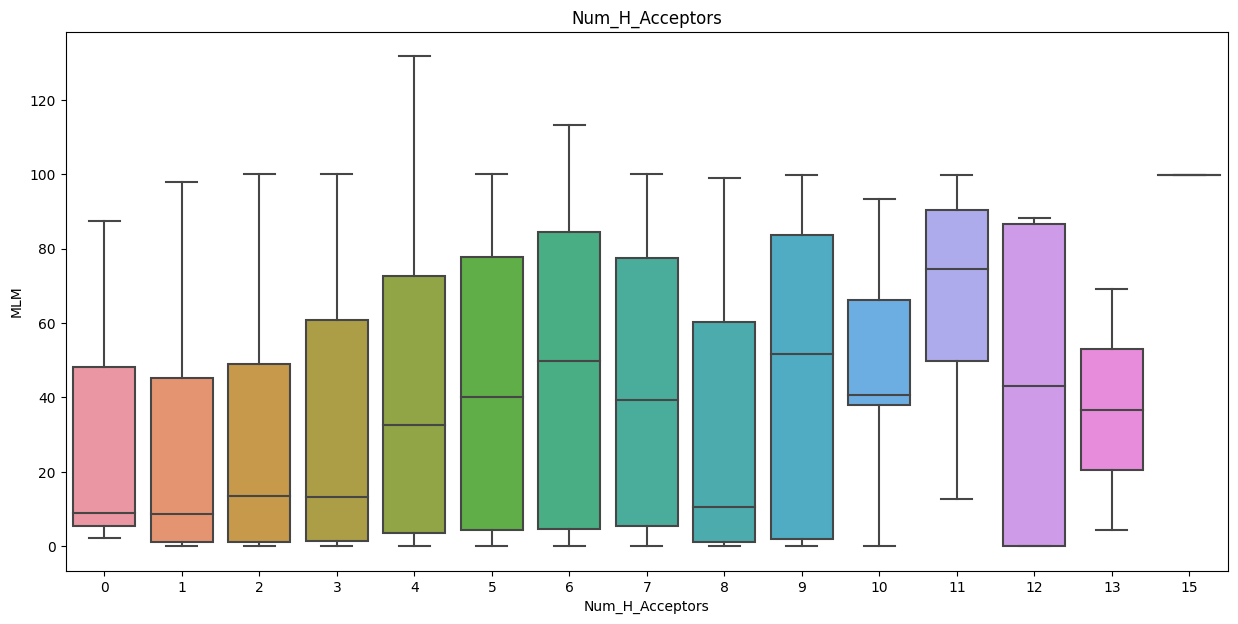

0 []


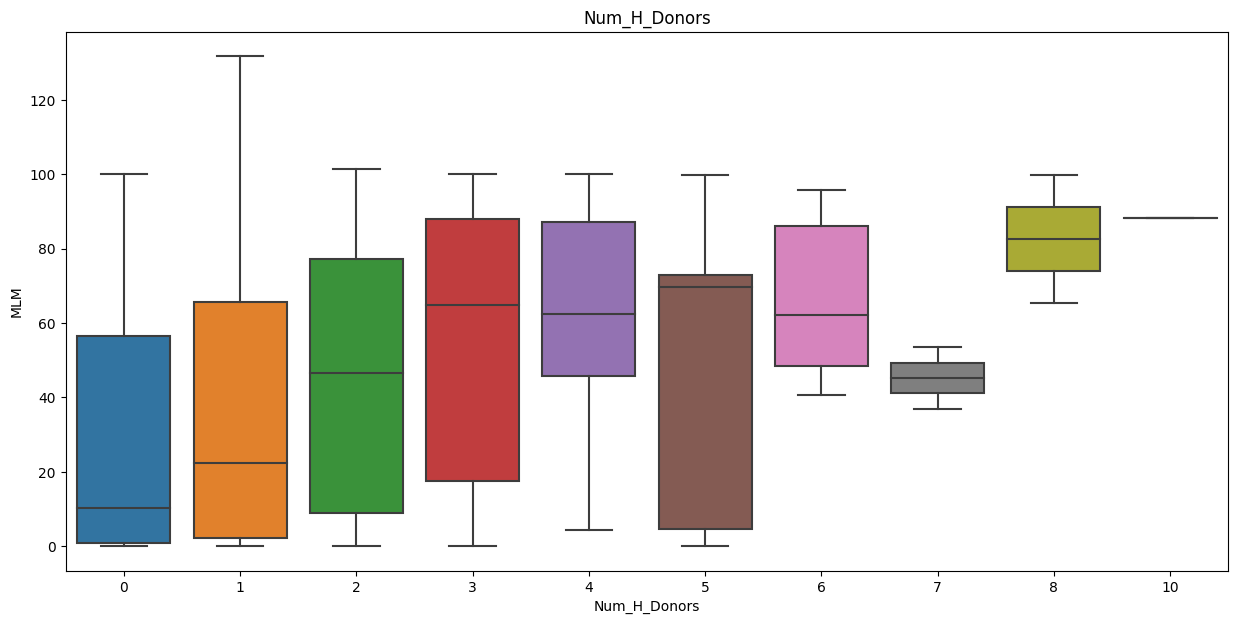

0 []


In [62]:
num_quantile_grp_features = [col for col in train_df.columns if (col.find('_quantile')>=0) & (col.find('_grp')>=0)]
cat_features = num_quantile_grp_features + ['Num_H_Acceptors','Num_H_Donors'] #,'Num_RotatableBonds']

for f in cat_features:
    plt.figure(figsize=(15,7))
    sns.boxplot(x=train_df[f],y=train_df['MLM'])
    plt.title(f)
    plt.show()
    only_test = list(set(test_df[f].unique())-set(train_df[f].unique()))
    print(len(only_test),only_test)

In [63]:
for target in CFG.TARGET:
    calculator = CategoricalQuantileCalculator()
    calculator.fit(
        data=train_df,
        test_data=test_df,
        target_feature=target,
        cat_features=cat_features,
        subset_depth=CFG.SUBSET_DEPTH,
    )
    train_df = calculator.transform(train_df,prefix=f'{target}_')
    test_df  = calculator.transform(test_df ,prefix=f'{target}_')

> Get quantiles of target by categorical features (depth=2)


Subset: Molecular_PolarSurfaceArea_quantile11_grp + Num_H_Acceptors: 100%|██████████| 21/21 [00:01<00:00, 16.14it/s]


> Get quantiles of target by categorical features (depth=2)


Subset: Molecular_PolarSurfaceArea_quantile11_grp + Num_H_Acceptors: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]


In [64]:
print(train_df.shape)
train_df.head()

(3552, 304)


,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,rdkit1,rdkit2,rdkit3,rdkit4,rdkit5,rdkit6,rdkit7,rdkit8,rdkit9,rdkit14,rdkit15,rdkit16,rdkit25,rdkit26,rdkit27,rdkit28,rdkit29,rdkit30,rdkit31,rdkit32,rdkit33,rdkit34,rdkit35,rdkit36,rdkit37,rdkit38,rdkit39,rdkit40,rdkit41,rdkit42,rdkit43,rdkit44,rdkit45,rdkit46,rdkit47,rdkit48,rdkit49,rdkit50,rdkit51,rdkit52,rdkit53,rdkit54,rdkit55,rdkit56,rdkit57,rdkit58,rdkit59,rdkit60,rdkit61,rdkit62,rdkit63,rdkit64,rdkit65,rdkit66,rdkit67,rdkit68,rdkit69,rdkit70,rdkit71,rdkit72,rdkit73,rdkit74,rdkit75,rdkit76,rdkit77,rdkit78,rdkit79,rdkit80,rdkit81,rdkit82,rdkit83,rdkit84,rdkit85,rdkit86,rdkit87,rdkit88,rdkit89,rdkit90,rdkit91,rdkit92,rdkit93,rdkit94,rdkit95,rdkit96,rdkit97,rdkit98,rdkit99,rdkit100,rdkit101,rdkit102,rdkit103,rdkit104,rdkit105,rdkit106,rdkit107,rdkit108,rdkit109,rdkit110,rdkit111,rdkit112,rdkit113,rdkit114,rdkit115,rdkit116,rdkit117,rdkit118,rdkit119,rdkit120,rdkit121,rdkit122,rdkit123,rdkit124,rdkit125,rdkit126,rdkit127,rdkit128,rdkit129,rdkit130,rdkit131,rdkit132,rdkit133,rdkit134,rdkit135,rdkit136,rdkit137,rdkit138,rdkit139,rdkit140,rdkit141,rdkit142,rdkit143,rdkit144,rdkit145,rdkit146,rdkit147,rdkit148,rdkit149,rdkit150,rdkit151,rdkit152,rdkit153,rdkit154,rdkit155,rdkit156,rdkit157,rdkit158,rdkit159,rdkit160,rdkit161,rdkit162,rdkit163,rdkit164,rdkit165,rdkit166,rdkit167,rdkit168,rdkit169,rdkit170,rdkit171,rdkit172,rdkit173,rdkit174,rdkit175,rdkit176,rdkit177,rdkit178,rdkit179,rdkit180,rdkit181,rdkit182,rdkit183,rdkit184,rdkit185,rdkit186,rdkit187,rdkit188,rdkit189,rdkit190,rdkit191,AlogP_quantile11_grp,Molecular_Weight_quantile11_grp,LogD_quantile11_grp,Molecular_PolarSurfaceArea_quantile11_grp,MLM_AlogP_quantile11_grp_Avg,MLM_AlogP_quantile11_grp_Q25,MLM_AlogP_quantile11_grp_Q50,MLM_AlogP_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp_Q75,MLM_LogD_quantile11_grp_Avg,MLM_LogD_quantile11_grp_Q25,MLM_LogD_quantile11_grp_Q50,MLM_LogD_quantile11_grp_Q75,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_Num_H_Acceptors_Avg,MLM_Num_H_Acceptors_Q25,MLM_Num_H_Acceptors_Q50,MLM_Num_H_Acceptors_Q75,MLM_Num_H_Donors_Avg,MLM_Num_H_Donors_Q25,MLM_Num_H_Donors_Q50,MLM_Num_H_Donors_Q75,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_AlogP_quantile11_grp&Num_H_Donors_Avg,MLM_AlogP_quantile11_grp&Num_H_Donors_Q25,MLM_AlogP_quantile11_grp&Num_H_Donors_Q50,MLM_AlogP_quantile11_grp&Num_H_Donors_Q75,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Avg,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q25,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q50,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q75,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceAr

<br>

## Truncated SVD
- 참조 : [Kaggle](https://www.kaggle.com/code/xiafire/lb-t15-msci-multiome-catboostregressor)

In [65]:
from sklearn.decomposition import PCA, TruncatedSVD

In [66]:
# from sklearn.preprocessing import StandardScaler
# for col in fps_names:
#     scaler = StandardScaler()
#     train_df[col] = scaler.fit_transform(np.array(train_df[col]).reshape(-1,1))
#     test_df [col] = scaler.transform(np.array(test_df[col]).reshape(-1,1))

In [67]:
# features = train_df.columns.difference(CFG.TARGET)

In [68]:
# train_input = train_df[features]
# test_input  = test_df [features]

# pca_input = TruncatedSVD(n_components=256, random_state=CFG.SEED)
# train_input = pca_input.fit_transform(train_input)
# test_input  = pca_input.fit_transform(test_input)
# print(pca_input.explained_variance_ratio_.sum())

# train_df.drop(features,axis=1,inplace=True)
# test_df .drop(features,axis=1,inplace=True)

# for i,(tr_value,te_value) in enumerate(zip(train_input.T,test_input.T)):
#     train_df[f'tsvd_{i+1}'] = tr_value
#     test_df [f'tsvd_{i+1}'] = te_value

In [69]:
# plt.figure(figsize=(15,7))
# sns.scatterplot(x=train_df['tsvd_1'],y=train_df['HLM'])
# plt.grid()
# plt.show()

<br>

## Memory Reduce

In [70]:
train_df, _ = reduce_mem_usage(train_df,verbose=False)
test_df , _ = reduce_mem_usage(test_df ,verbose=False)

In [71]:
train_df.to_parquet('./out/train_df.parquet')
test_df .to_parquet('./out/test_df.parquet')

<br></br>

# Modeling

## Weighted Ensemble

In [72]:
train_fn = train_df.copy()
test_fn  = test_df .copy()

In [73]:
train_fn.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,rdkit1,rdkit2,rdkit3,rdkit4,rdkit5,rdkit6,rdkit7,rdkit8,rdkit9,rdkit14,rdkit15,rdkit16,rdkit25,rdkit26,rdkit27,rdkit28,rdkit29,rdkit30,rdkit31,rdkit32,rdkit33,rdkit34,rdkit35,rdkit36,rdkit37,rdkit38,rdkit39,rdkit40,rdkit41,rdkit42,rdkit43,rdkit44,rdkit45,rdkit46,rdkit47,rdkit48,rdkit49,rdkit50,rdkit51,rdkit52,rdkit53,rdkit54,rdkit55,rdkit56,rdkit57,rdkit58,rdkit59,rdkit60,rdkit61,rdkit62,rdkit63,rdkit64,rdkit65,rdkit66,rdkit67,rdkit68,rdkit69,rdkit70,rdkit71,rdkit72,rdkit73,rdkit74,rdkit75,rdkit76,rdkit77,rdkit78,rdkit79,rdkit80,rdkit81,rdkit82,rdkit83,rdkit84,rdkit85,rdkit86,rdkit87,rdkit88,rdkit89,rdkit90,rdkit91,rdkit92,rdkit93,rdkit94,rdkit95,rdkit96,rdkit97,rdkit98,rdkit99,rdkit100,rdkit101,rdkit102,rdkit103,rdkit104,rdkit105,rdkit106,rdkit107,rdkit108,rdkit109,rdkit110,rdkit111,rdkit112,rdkit113,rdkit114,rdkit115,rdkit116,rdkit117,rdkit118,rdkit119,rdkit120,rdkit121,rdkit122,rdkit123,rdkit124,rdkit125,rdkit126,rdkit127,rdkit128,rdkit129,rdkit130,rdkit131,rdkit132,rdkit133,rdkit134,rdkit135,rdkit136,rdkit137,rdkit138,rdkit139,rdkit140,rdkit141,rdkit142,rdkit143,rdkit144,rdkit145,rdkit146,rdkit147,rdkit148,rdkit149,rdkit150,rdkit151,rdkit152,rdkit153,rdkit154,rdkit155,rdkit156,rdkit157,rdkit158,rdkit159,rdkit160,rdkit161,rdkit162,rdkit163,rdkit164,rdkit165,rdkit166,rdkit167,rdkit168,rdkit169,rdkit170,rdkit171,rdkit172,rdkit173,rdkit174,rdkit175,rdkit176,rdkit177,rdkit178,rdkit179,rdkit180,rdkit181,rdkit182,rdkit183,rdkit184,rdkit185,rdkit186,rdkit187,rdkit188,rdkit189,rdkit190,rdkit191,AlogP_quantile11_grp,Molecular_Weight_quantile11_grp,LogD_quantile11_grp,Molecular_PolarSurfaceArea_quantile11_grp,MLM_AlogP_quantile11_grp_Avg,MLM_AlogP_quantile11_grp_Q25,MLM_AlogP_quantile11_grp_Q50,MLM_AlogP_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp_Q75,MLM_LogD_quantile11_grp_Avg,MLM_LogD_quantile11_grp_Q25,MLM_LogD_quantile11_grp_Q50,MLM_LogD_quantile11_grp_Q75,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_Num_H_Acceptors_Avg,MLM_Num_H_Acceptors_Q25,MLM_Num_H_Acceptors_Q50,MLM_Num_H_Acceptors_Q75,MLM_Num_H_Donors_Avg,MLM_Num_H_Donors_Q25,MLM_Num_H_Donors_Q50,MLM_Num_H_Donors_Q75,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_AlogP_quantile11_grp&Num_H_Donors_Avg,MLM_AlogP_quantile11_grp&Num_H_Donors_Q25,MLM_AlogP_quantile11_grp&Num_H_Donors_Q50,MLM_AlogP_quantile11_grp&Num_H_Donors_Q75,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Avg,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q25,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q50,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q75,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceAr

In [79]:
def multi_rmse(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse_list = []
    for i in range(y_true.shape[1]):
        rmse = mean_squared_error(y_true=y_true[:,i],y_pred=y_pred[:,i])**0.5
        rmse_list.append(rmse)

    return np.mean(rmse_list)

In [80]:
# https://stackoverflow.com/questions/66785587/how-do-i-use-validation-sets-on-multioutputregressor-for-xgbregressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.multioutput import MultiOutputRegressor

from sklearn.utils.validation import _check_fit_params
from sklearn.base import is_classifier
from sklearn.utils.fixes import delayed
from joblib import Parallel
from sklearn.multioutput import _fit_estimator

class Evalset_MultiOutputRegressor(MultiOutputRegressor):

    def fit(self, X, y, sample_weight=None, **fit_params):
        """ Fit the model to data.
        Fit a separate model for each output variable.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data.
        y : {array-like, sparse matrix} of shape (n_samples, n_outputs)
            Multi-output targets. An indicator matrix turns on multilabel
            estimation.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Only supported if the underlying regressor supports sample
            weights.
        **fit_params : dict of string -> object
            Parameters passed to the ``estimator.fit`` method of each step.
            .. versionadded:: 0.23
        Returns
        -------
        self : object
        """

        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement"
                             " a fit method")

        X, y = self._validate_data(X, y,
                                   force_all_finite=False,
                                   multi_output=True, accept_sparse=True)

        if is_classifier(self):
            check_classification_targets(y)

        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for "
                             "multi-output regression but has only one.")

        if (sample_weight is not None and
                not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support"
                             " sample weights.")

        fit_params_validated = _check_fit_params(X, fit_params)
        [(X_test, Y_test)] = fit_params_validated.pop('eval_set')
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_estimator)(
                self.estimator, X, y[:, i], sample_weight,
                **fit_params_validated, eval_set=[(X_test, Y_test[:, i])]) #.iloc로 수정
            for i in range(y.shape[1]))
        return self

In [81]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,hyperparameters,weight=['equal','balanced'],inverse_transform=None):
        super().__init__()

        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"

        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self._get_regressors()

    def _get_regressors(self):
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
        }

        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }

        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }

        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'reg:squarederror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }

        params_lightgbm = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }

        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations']//10,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }

        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }

        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }

        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 5,
        }

        self.regressors = [
            #MultiOutputRegressor(LinearRegression()),
            #MultiOutputRegressor(RidgeCV(**params_ridge)),
            #MultiOutputRegressor(LassoCV(**params_lasso)),
            MultiOutputRegressor(ElasticNetCV(**params_elasticnet)),
            Evalset_MultiOutputRegressor(XGBRegressor(**params_xgboost)),
            Evalset_MultiOutputRegressor(LGBMRegressor(**params_lightgbm)),
            MultiOutputRegressor(ExtraTreesRegressor(**params_extratrees)),
            CatBoostRegressor(**params_catboost1),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
        ]
        self.regressors_name = [
            #'OLS',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            'XGBoost',
            'LightGBM',
            'ExtraTrees',
            'CatBoost1',
            'CatBoost2',
            'CatBoost3',
        ]

    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred

    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred

    def _set_0to100(self,pred):
        pred = np.array(pred).flatten()
        if np.where((pred<0)|(pred>100),1,0).sum()>0:
            pred = [0 if x<0 else
                    100 if x>100 else
                    x for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred

    def _rescale_0to100(self,pred,minmax=None):
        pred = np.array(pred)

        if minmax is None:
            _min = pred.min(axis=0)
            _max = pred.max(axis=0)
        else:
            _min, _max = minmax

        pred = (pred - _min) / (_max-_min)
        pred = 100*pred

        return pred, (_min,_max)

    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]

        self.features = X.columns
        self.oh_features = X_oh.columns

        tr_true = np.array(y)
        va_true = np.array(y_val)
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)

        self.minimum_value = 0   #min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = 100 #max(np.nanmax(y),np.nanmax(y_val))

        self.cat_features = cat_features
        self.scores = []
        self.weights = []
        self.fitting_elapsed = []
        self.minmax_list = []

        fit_iter = 0
        for regressor_name,regressor in zip(self.regressors_name,self.regressors):
            fit_iter+=1
            s = time.time()

            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('CatBoost')>=0:
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=self.hyperparameters['iterations']//50,
                    #verbose=True,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                fit_params = {
                    'eval_set':[(X_val_oh.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_oh.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                fit_params = {
                    'eval_set':[(X_val_tmp.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_tmp.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh.values,y.values)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))

            tr_pred = np.array(tr_pred)
            va_pred = np.array(va_pred)

            #tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            #va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)

            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)

            tr_pred = self._set_0to100(tr_pred)
            va_pred = self._set_0to100(va_pred)

#             tr_pred, minmax = self._rescale_0to100(tr_pred,minmax=None)
#             va_pred, _      = self._rescale_0to100(va_pred,minmax=minmax)

            # global _tr_pred, _va_pred, _tr_true, _va_true
            # _tr_pred,_va_pred = tr_pred,va_pred
            # _tr_true,_va_true = tr_true,va_true

            tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
            tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
            va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
            va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
            tr_score = 0.5*tr_score_1+0.5*tr_score_2
            va_score = 0.5*va_score_1+0.5*va_score_2

            e = time.time()
            self.scores.append(va_score)
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            #self.minmax_list.append(minmax)
            self.minmax_list.append([0,100])

            if verbose:
                blank = ' '*(11-len(regressor_name))
                fit_iter_str = str(fit_iter).zfill(len(str(len(self.regressors))))
                fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                    .format(fit_iter_str,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
                print(fit_progress)

        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)

        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)

        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)

        tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
        tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
        va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
        va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
        ens_tr_score = 0.5*tr_score_1+0.5*tr_score_2
        ens_va_score = 0.5*va_score_1+0.5*va_score_2

        if verbose:
            ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
            print(ens_fit_progress)

        self.ensemble_score = ens_va_score

    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"

        pred_list = []
        for regressor_name,regressor,minmax in zip(self.regressors_name,self.regressors,self.minmax_list):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))

            y_pred = regressor.predict(dataset)
            #y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)

            if self.inverse_transform is not None:
                y_pred = self.inverse_transform(np.array(y_pred))
                y_pred = self._set_inf_to_maximum(y_pred,self.maximum_value)

            y_pred = self._set_0to100(y_pred)
            #y_pred, _ = self._rescale_0to100(y_pred,minmax=minmax)

            pred_list.append(y_pred)

        final_pred = []
        for pred,weight in zip(pred_list,self.weights):
            pred = np.array(pred)*weight
            final_pred.append(pred)
        final_pred = np.sum(final_pred,axis=0)

        return final_pred

    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'scores' : self.scores,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'ensemble_score' : self.ensemble_score,
            'minmax_list' : self.minmax_list,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.scores = save_dict['scores']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.ensemble_score = save_dict['ensemble_score']
            self.minmax_list = save_dict['minmax_list']

In [82]:
def load_model(hyperparameters,path):
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    ensemble_model.load_model(path)
    return ensemble_model

In [83]:
from sklearn.model_selection import KFold

In [84]:
hyperparameters = {
    'max_depth' : 5,
    'random_state' : 0,
    'learning_rate' : 0.1,
    'iterations' : 20000,
    'early_stopping_rounds' : 300,
}

In [85]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# unique인 컬럼 제외
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)
    print('deleted:',len(unique_cols))

In [86]:
# cat_features = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# X     [cat_features] = X     [cat_features].astype(str)
# X_test[cat_features] = X_test[cat_features].astype(str)

In [87]:
X.shape, y.shape

((3552, 302), (3552, 2))

In [88]:
gc_collect_all()

gc_collect: 65


In [89]:
%%time

save_path = './mc/kf_weiens_catall/k{}.pickle'
gc_collect_all(verbose=False)

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

models = []
scores = []
k=0
for tr_idx,val_idx in kf.split(X,y):
    k+=1

    print('-'*100)
    print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
    print('-'*100)

    # kfold dataset
    X_tr, X_va = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

    # define the model
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    # cat만 가져오기
    ensemble_model.regressors = ensemble_model.regressors[-3:]
    ensemble_model.regressors_name = ensemble_model.regressors_name[-3:]

    # fit the model
    ensemble_model.fit(
        X_tr,y_tr,
        eval_set=[(X_va,y_va)],
        oh_set=[(X_tr,X_va)],
        cat_features=cat_features,
        verbose=True,
    )

    # save the model
    ensemble_model.save_model(save_path.format(k))
    tr_pred = ensemble_model.predict(X_tr,X_tr)
    va_pred = ensemble_model.predict(X_va,X_va)

    if inverse_transform is not None:
        tr_true = inverse_transform(y_tr)
        va_true = inverse_transform(y_va)
    else:
        tr_true = np.array(y_tr)
        va_true = np.array(y_va)

    # train
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[1] Training dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # validation
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[2] Validation dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # caculate score
    score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
    score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
    score = 0.5*score_1+0.5*score_2

    # append inner loop
    models.append(ensemble_model)
    scores.append([k,len(X_tr),len(X_va),score])

Output hidden; open in https://colab.research.google.com to view.

In [90]:
# def func(x):
#     upper = 70
#     offset=0.1
#     new_x = [min(100,v*(1+offset)) if v>=upper else
#              max(0,v*(1-offset)) if v<=(100-upper) else
#              v for v in x]
#     return np.array(new_x)

In [91]:
# i=0
# asis = mean_squared_error(y_pred=va_pred[:,i],y_true=va_true[:,i])**0.5
# tobe = mean_squared_error(y_pred=func(va_pred[:,i]),y_true=va_true[:,i])**0.5
# asis,tobe

In [92]:
# plt.figure(figsize=(15,7))
# sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
# abline(0,1)
# plt.grid()
# plt.show()

# plt.figure(figsize=(15,7))
# sns.scatterplot(x=va_true[:,0],y=func(va_pred[:,0]))
# abline(0,1)
# plt.grid()
# plt.show()

In [93]:
score_df = pd.DataFrame(scores,columns=['k','n_train','n_val','rmse'])
display(score_df)

score_df.rmse.mean()
# 30.42035477905302

,k,n_train,n_val,rmse
0,1,2841,711,31.140600
1,2,2841,711,30.682204
2,3,2842,710,29.444009
3,4,2842,710,30.191654
4,5,2842,710,30.643307


30.42035477905302

In [94]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

In [95]:
# cat_features = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# X     [cat_features] = X     [cat_features].astype(str)
# X_test[cat_features] = X_test[cat_features].astype(str)

In [96]:
path = './mc/kf_weiens_catall/k{}.pickle'
model_list = [load_model(hyperparameters,path.format(k)) for k in range(1,6)]

features = model_list[0].features
oh_features = model_list[0].oh_features

tr_pred = np.mean([model.predict(X[features],X[oh_features]) for model in model_list],axis=0)
tr_pred = pd.DataFrame(tr_pred,index=X.index)

te_pred = np.mean([model.predict(X_test[features],X_test[oh_features]) for model in model_list],axis=0)
te_pred = pd.DataFrame(te_pred,index=X_test.index)

In [97]:
# tr_pred = tr_pred.apply(set_0to100)
# te_pred = pd.DataFrame(target_transform.inverse_transform(y)).apply(set_0to100)

In [98]:
if inverse_transform is not None:
    y_new = inverse_transform(y)
else:
    y_new = np.array(y)

In [101]:
multi_rmse(y_true=y_new,y_pred=tr_pred)
# 25.050850936786453

25.050850936786453

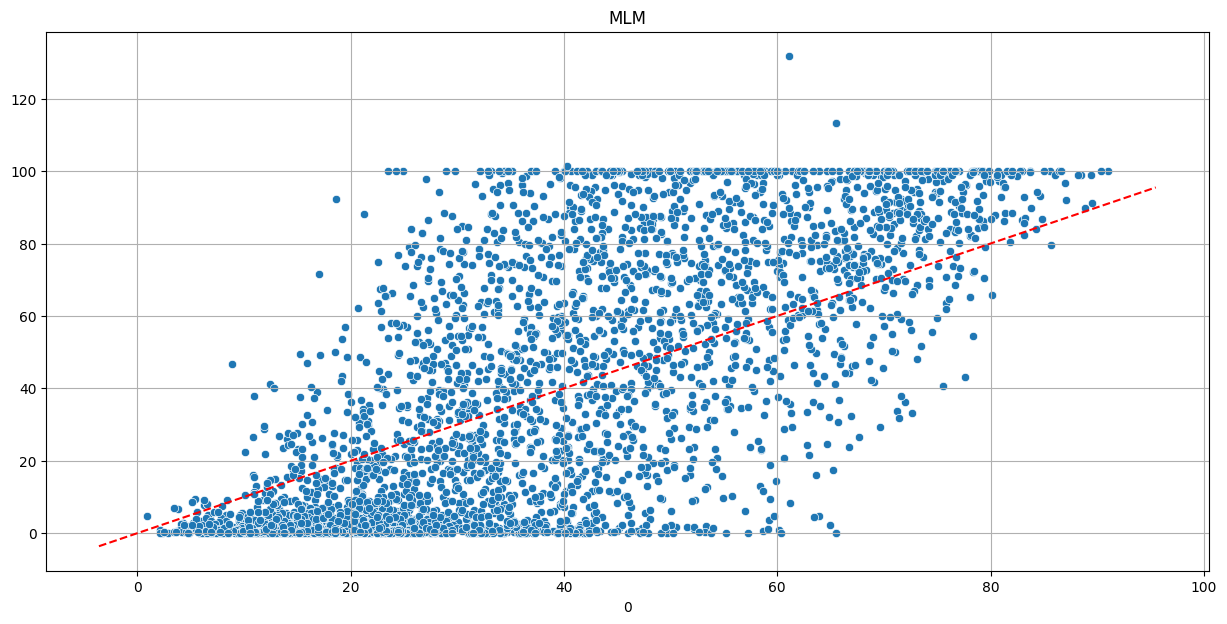

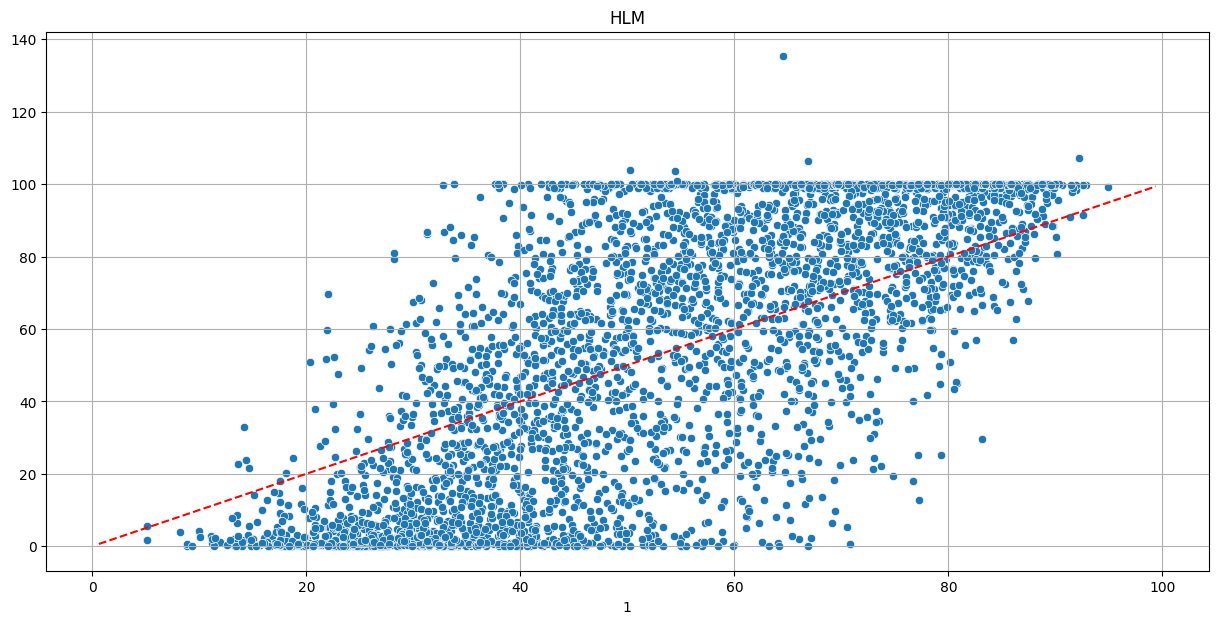

In [100]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,0],y=y_new[:,0])
abline(0,1)
plt.grid()
plt.title('MLM')
plt.show()

plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,1],y=y_new[:,1])
abline(0,1)
plt.grid()
plt.title('HLM')
plt.show()

In [102]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred

In [103]:
submit.tail()

,id,MLM,HLM
478,TEST_478,7.849399,25.592340
479,TEST_479,72.877462,82.957273
480,TEST_480,52.224559,71.473835
481,TEST_481,67.692612,80.214601
482,TEST_482,32.065701,62.647299


In [104]:
submit.min(),submit.max()

(id      TEST_000
 MLM     3.482111
 HLM    13.425349
 dtype: object,
 id      TEST_482
 MLM    83.475122
 HLM    90.470188
 dtype: object)

In [105]:
# public :  (identity)
submit.to_csv('./out/24_new_chemical_data.csv',index=False)

<br>

## Stacking

In [106]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

# unique인 컬럼 제외
# (1) X
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)

In [107]:
org_path = './mc/kf_weiens_catall/k{}.pickle'
model_list = [load_model(hyperparameters,org_path.format(k)) for k in range(1,6)]

features    = model_list[0].features
oh_features = model_list[0].oh_features
X = X[features]
X_test = X_test[features]

tr_pred = pd.DataFrame(index=X.index)
te_pred = pd.DataFrame(index=X_test.index)

tr_pred[['pred1','pred2']] = np.mean([model.predict(X     ,X     ) for i,model in enumerate(model_list,1)],axis=0)
te_pred[['pred1','pred2']] = np.mean([model.predict(X_test,X_test) for i,model in enumerate(model_list,1)],axis=0)

# for i,model in enumerate(model_list,1):
#     tr_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X,X)
#     te_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X_test,X_test)

X_new      = pd.concat([X      ,tr_pred],axis=1)
X_test_new = pd.concat([X_test ,te_pred],axis=1)

----------------------------------------------------------------------------------------------------
> [K-Fold] 1/5
----------------------------------------------------------------------------------------------------
[1/3] CatBoost1  : loss=7.507, val_loss=19.202, elasped=54.1s
[2/3] CatBoost2  : loss=5.555, val_loss=18.989, elasped=81.5s
[3/3] CatBoost3  : loss=4.591, val_loss=19.111, elasped=125.9s
<Weighted Ensemble(weight='balanced')> loss=5.724, val_loss=18.865, elasped=261.5s


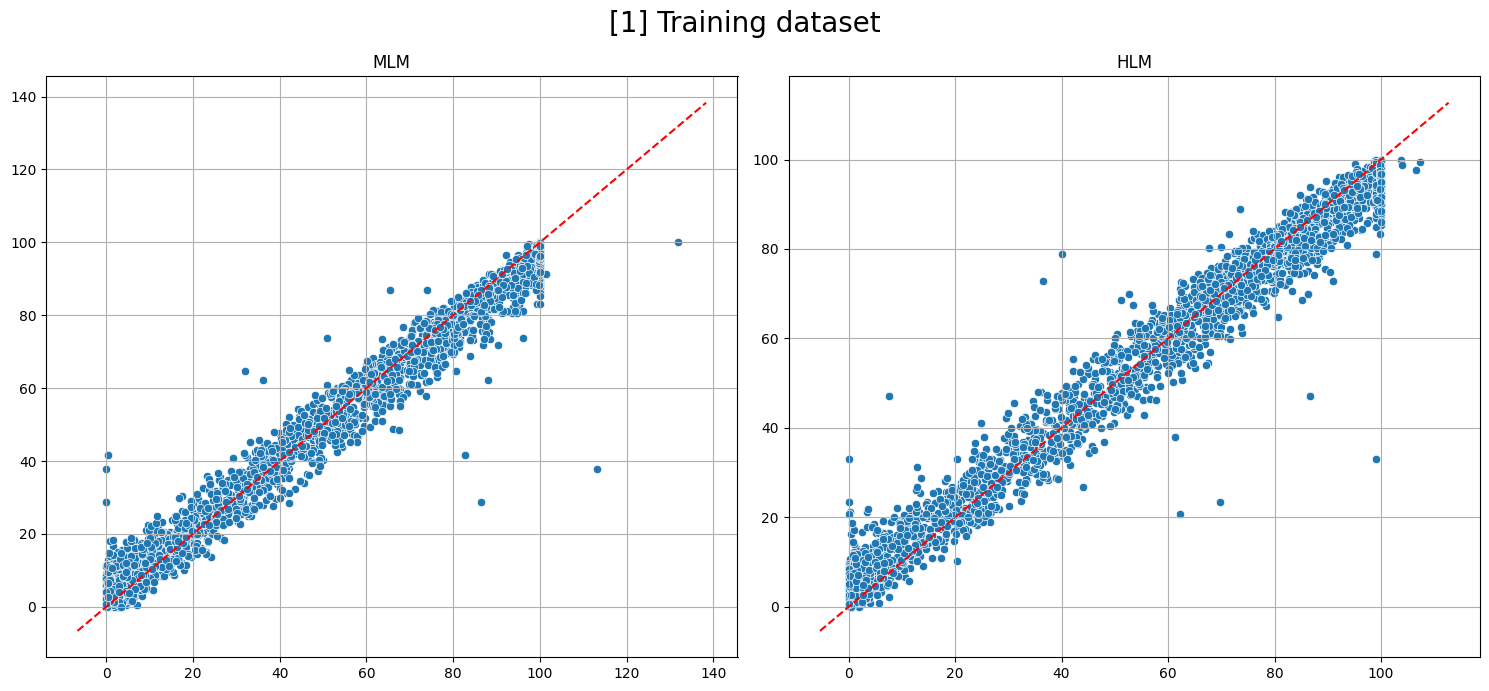

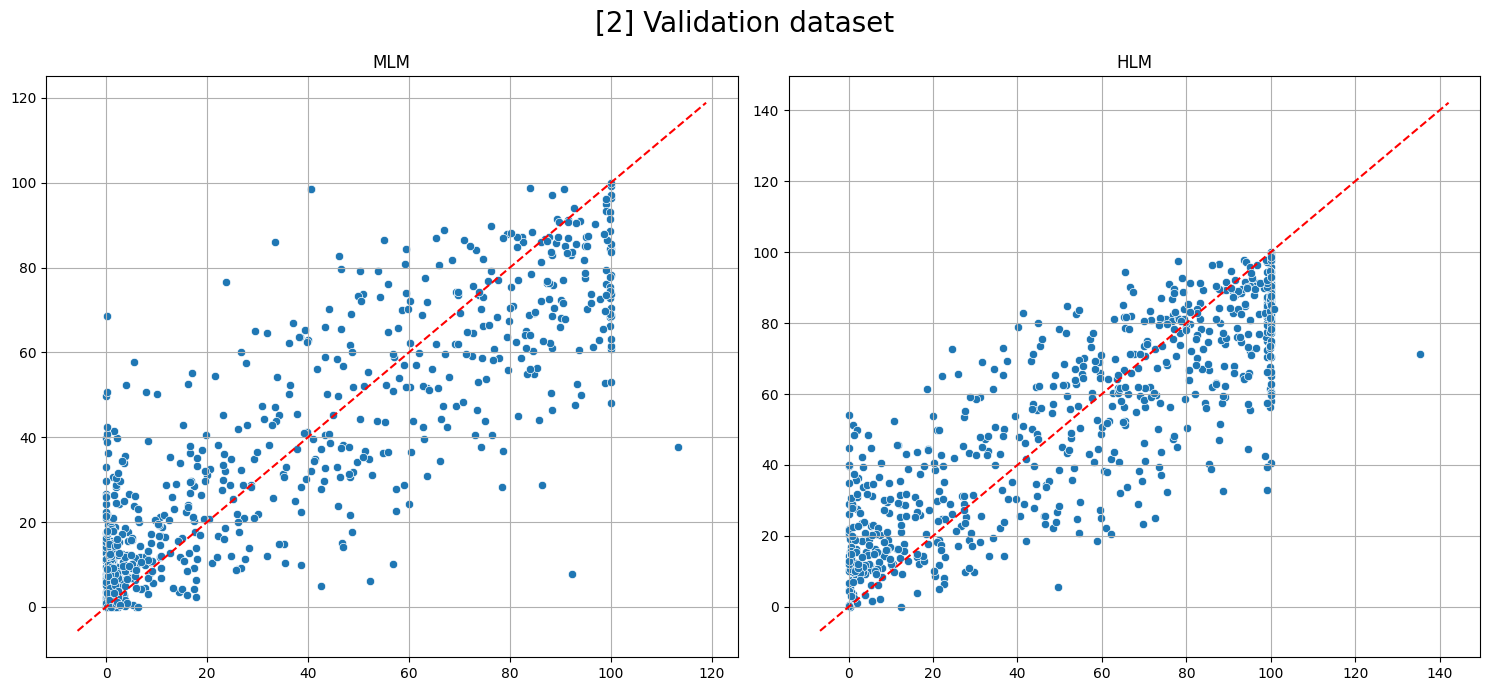

----------------------------------------------------------------------------------------------------
> [K-Fold] 2/5
----------------------------------------------------------------------------------------------------
[1/3] CatBoost1  : loss=7.490, val_loss=20.284, elasped=46.5s
[2/3] CatBoost2  : loss=7.889, val_loss=20.177, elasped=49.3s
[3/3] CatBoost3  : loss=6.471, val_loss=19.964, elasped=69.8s
<Weighted Ensemble(weight='balanced')> loss=7.158, val_loss=19.927, elasped=165.6s


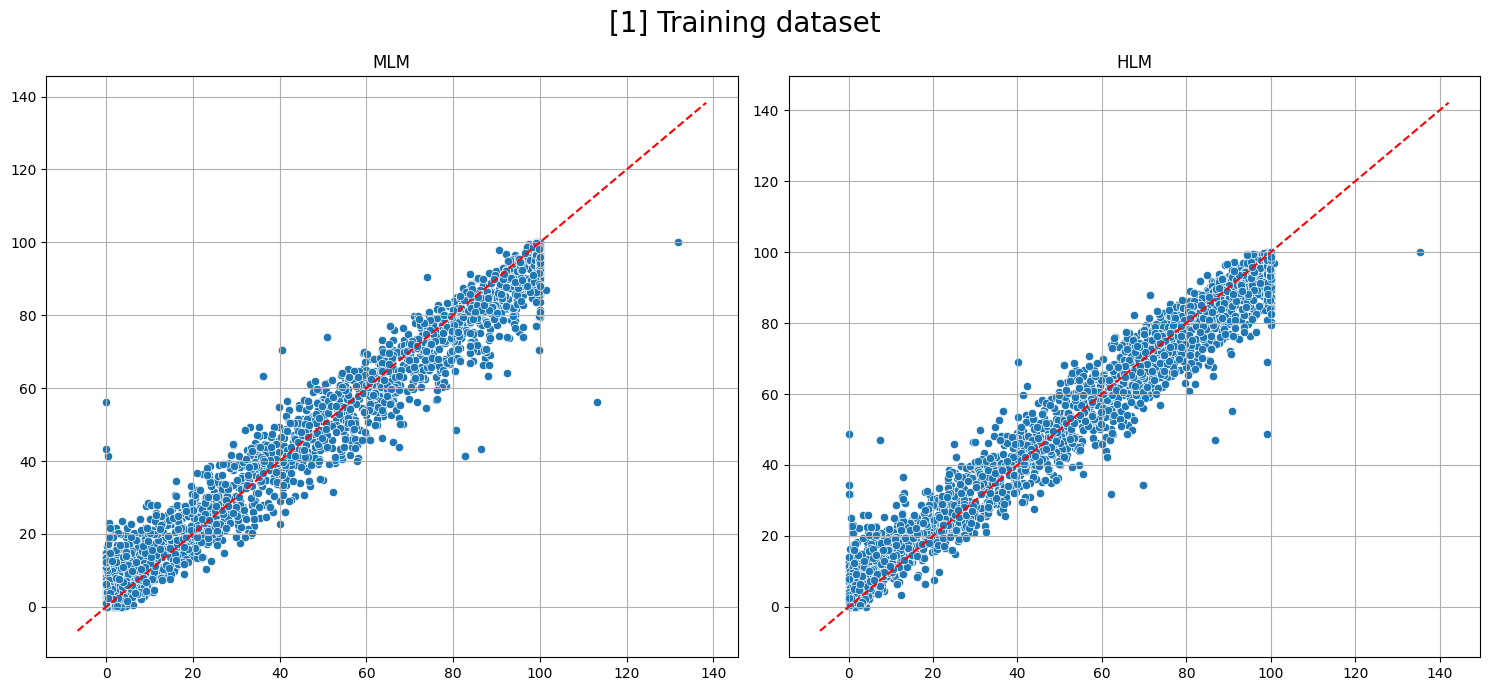

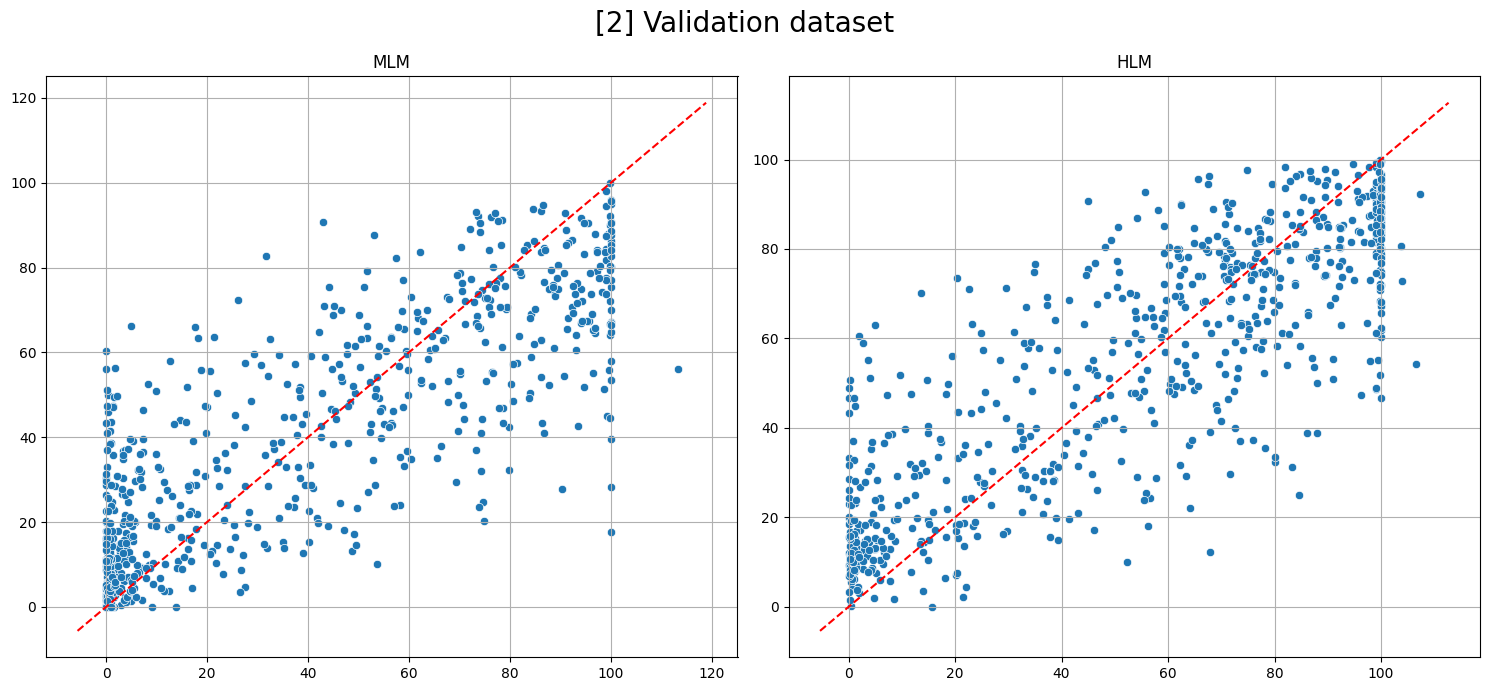

----------------------------------------------------------------------------------------------------
> [K-Fold] 3/5
----------------------------------------------------------------------------------------------------
[1/3] CatBoost1  : loss=4.480, val_loss=20.429, elasped=125.7s
[2/3] CatBoost2  : loss=6.903, val_loss=20.390, elasped=57.9s
[3/3] CatBoost3  : loss=6.787, val_loss=20.087, elasped=61.3s
<Weighted Ensemble(weight='balanced')> loss=5.901, val_loss=20.094, elasped=244.9s


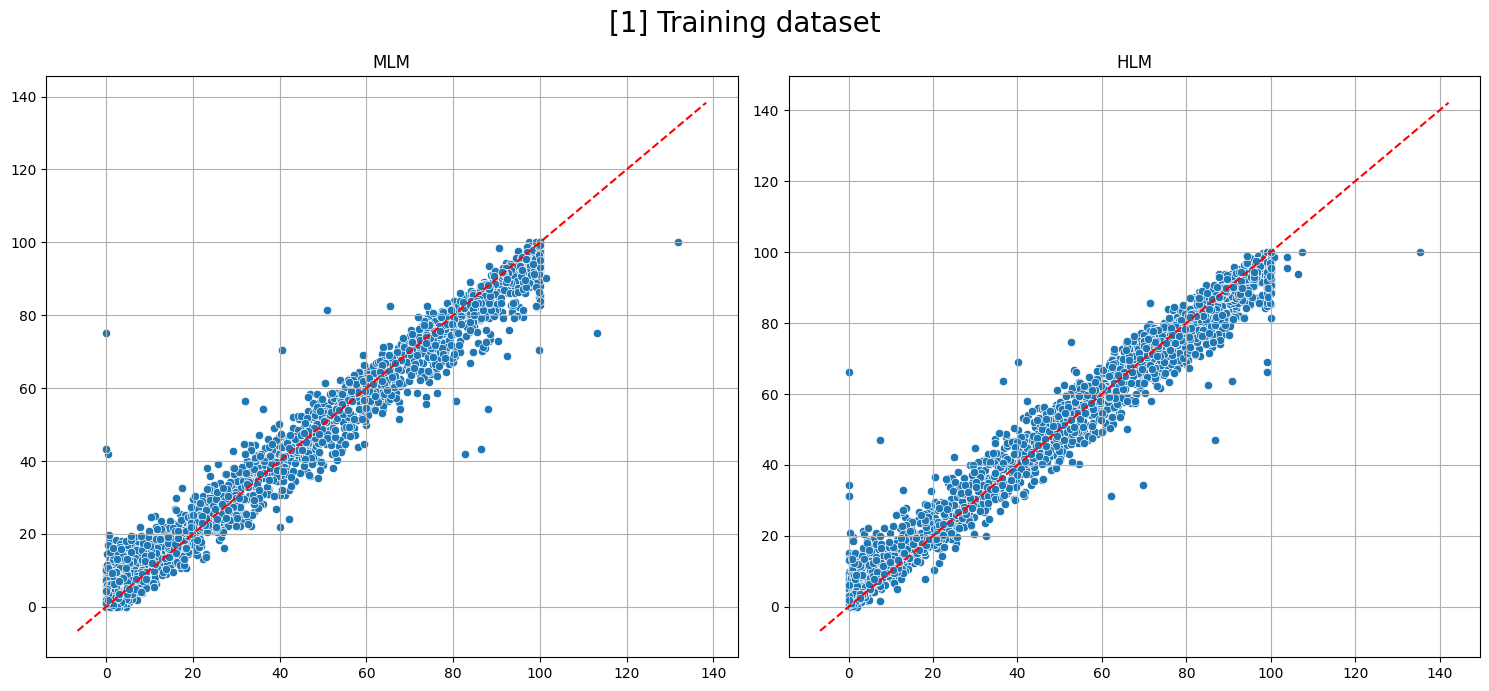

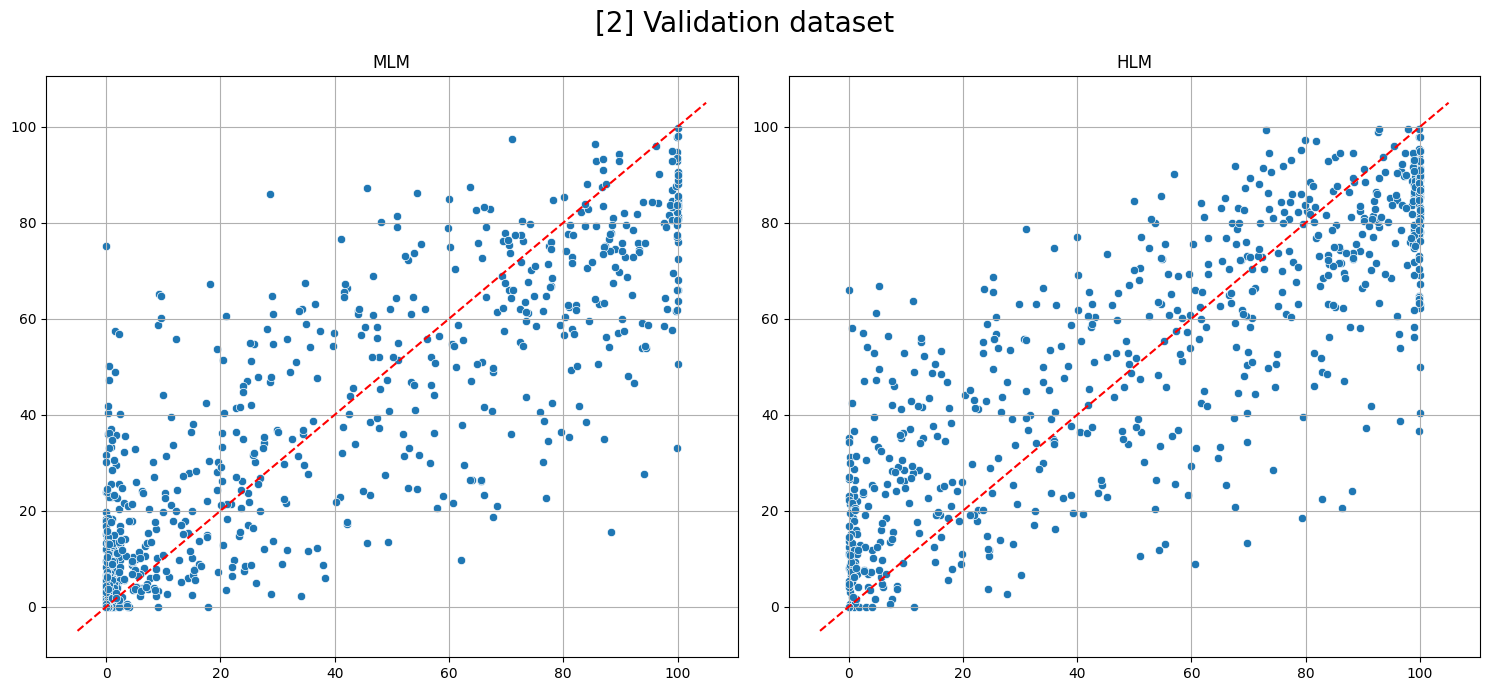

----------------------------------------------------------------------------------------------------
> [K-Fold] 4/5
----------------------------------------------------------------------------------------------------
[1/3] CatBoost1  : loss=9.691, val_loss=20.842, elasped=34.7s
[2/3] CatBoost2  : loss=6.502, val_loss=20.423, elasped=63.3s
[3/3] CatBoost3  : loss=7.296, val_loss=20.462, elasped=57.1s
<Weighted Ensemble(weight='balanced')> loss=7.656, val_loss=20.369, elasped=155.0s


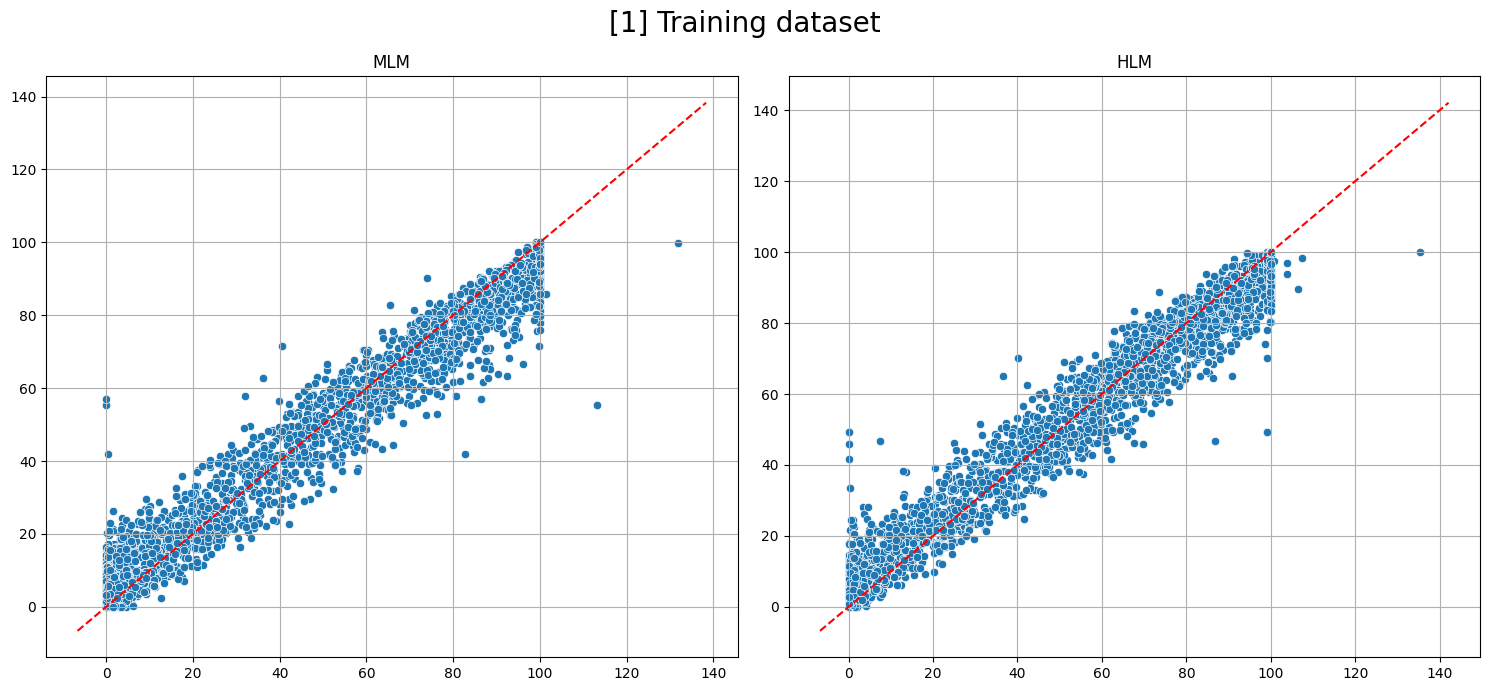

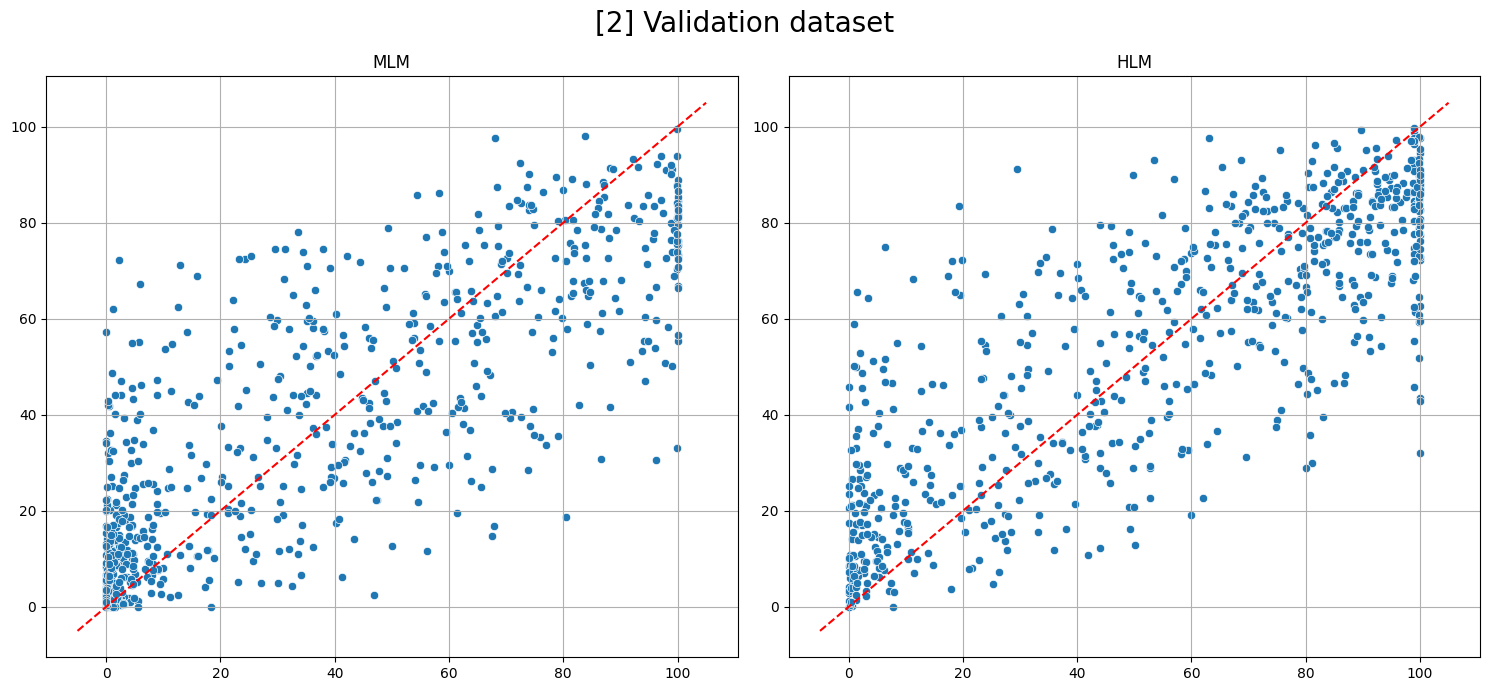

----------------------------------------------------------------------------------------------------
> [K-Fold] 5/5
----------------------------------------------------------------------------------------------------
[1/3] CatBoost1  : loss=6.740, val_loss=19.225, elasped=56.1s
[2/3] CatBoost2  : loss=6.245, val_loss=19.050, elasped=70.8s
[3/3] CatBoost3  : loss=6.252, val_loss=19.032, elasped=78.8s
<Weighted Ensemble(weight='balanced')> loss=6.312, val_loss=18.866, elasped=205.6s


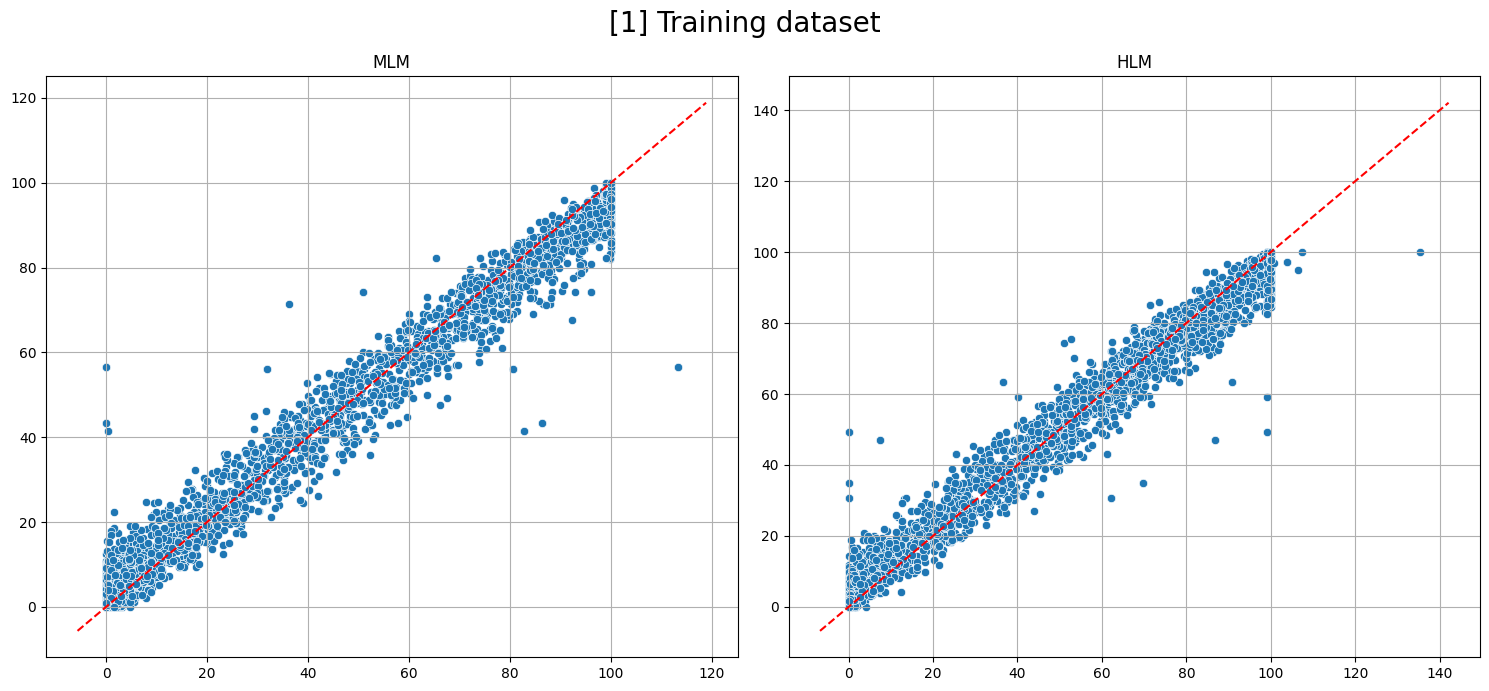

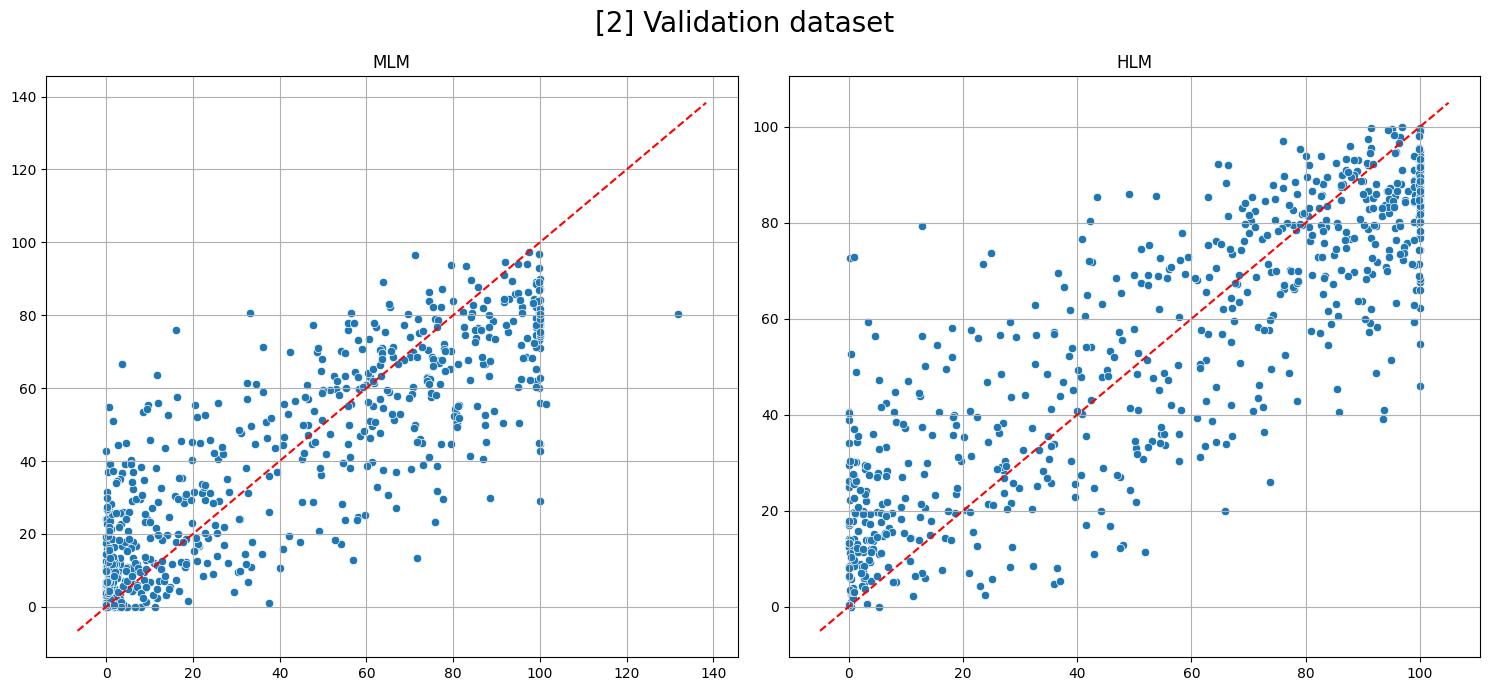

CPU times: user 29min 44s, sys: 21.8 s, total: 30min 5s
Wall time: 17min 25s


In [111]:
%%time

save_path = './mc/kf_weiens_catall/stacking_k{}.pickle'

gc_collect_all(verbose=False)

models = []
scores = []
k=0
for tr_idx,val_idx in kf.split(X,y):
    k+=1

    print('-'*100)
    print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
    print('-'*100)

    # kfold dataset
    X_tr, X_va = X_new.iloc[tr_idx], X_new.iloc[val_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

    # define the model
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    # cat만 가져오기
    ensemble_model.regressors = ensemble_model.regressors[-3:]
    ensemble_model.regressors_name = ensemble_model.regressors_name[-3:]

    # fit the model
    ensemble_model.fit(
        X_tr,y_tr,
        eval_set=[(X_va,y_va)],
        oh_set=[(X_tr,X_va)],
        cat_features=[],
        verbose=True,
    )

    # save the model
    ensemble_model.save_model(save_path.format(k))
    tr_pred = ensemble_model.predict(X_tr,X_tr)
    va_pred = ensemble_model.predict(X_va,X_va)

    if inverse_transform is not None:
        tr_true = inverse_transform(y_tr)
        va_true = inverse_transform(y_va)
    else:
        tr_true = np.array(y_tr)
        va_true = np.array(y_va)

    # train
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[1] Training dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # validation
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[2] Validation dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # caculate score
    score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
    score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
    score = 0.5*score_1+0.5*score_2

    # append inner loop
    models.append(ensemble_model)
    scores.append([k,len(X_tr),len(X_va),score])

In [112]:
score_df = pd.DataFrame(scores,columns=['k','n_train','n_val','rmse'])
score_df

,k,n_train,n_val,rmse
0,1,2841,711,18.864999
1,2,2841,711,19.926973
2,3,2842,710,20.093743
3,4,2842,710,20.368583
4,5,2842,710,18.865823


In [113]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

# unique인 컬럼 제외
# (1) X
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)

In [114]:
model_list = [load_model(hyperparameters,org_path.format(k)) for k in range(1,6)]

features    = model_list[0].features
oh_features = model_list[0].oh_features
X = X[features]
X_test = X_test[features]

tr_pred = pd.DataFrame(index=X.index)
te_pred = pd.DataFrame(index=X_test.index)

tr_pred[['pred1','pred2']] = np.mean([model.predict(X     ,X     ) for i,model in enumerate(model_list,1)],axis=0)
te_pred[['pred1','pred2']] = np.mean([model.predict(X_test,X_test) for i,model in enumerate(model_list,1)],axis=0)

# for i,model in enumerate(model_list,1):
#     tr_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X,X)
#     te_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X_test,X_test)

X_new      = pd.concat([X      ,tr_pred],axis=1)
X_test_new = pd.concat([X_test ,te_pred],axis=1)

In [115]:
stacking_path = './mc/kf_weiens_catall/stacking_k{}.pickle'
model_list = [load_model(hyperparameters,stacking_path.format(k)) for k in range(1,6)]

features = model_list[0].features
oh_features = model_list[0].oh_features

tr_pred = np.mean([model.predict(X_new[features],X_new[oh_features]) for model in model_list],axis=0)
tr_pred = pd.DataFrame(tr_pred,index=X.index)

te_pred = np.mean([model.predict(X_test_new[features],X_test_new[oh_features]) for model in model_list],axis=0)
te_pred = pd.DataFrame(te_pred,index=X_test.index)

In [116]:
# tr_pred = tr_pred.apply(set_0to100)
# te_pred = pd.DataFrame(target_transform.inverse_transform(y)).apply(set_0to100)

In [117]:
if inverse_transform is not None:
    y_new = inverse_transform(y)
else:
    y_new = np.array(y)
multi_rmse(y_true=tr_pred,y_pred=y_new)
# 8.750246226665261

8.750246226665261

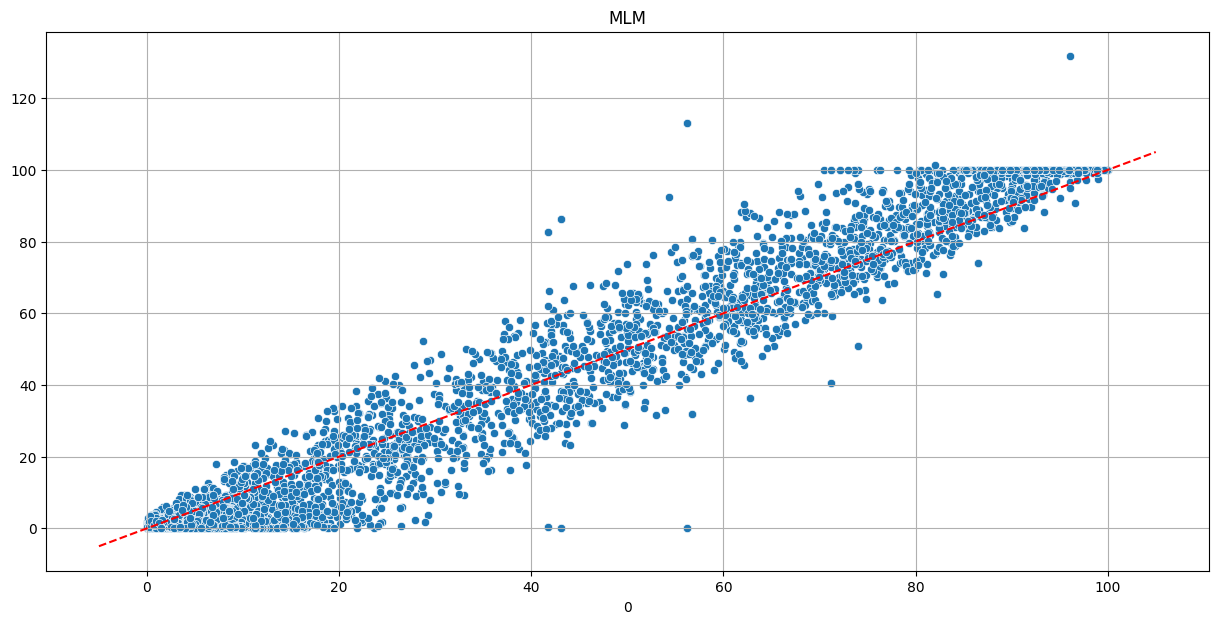

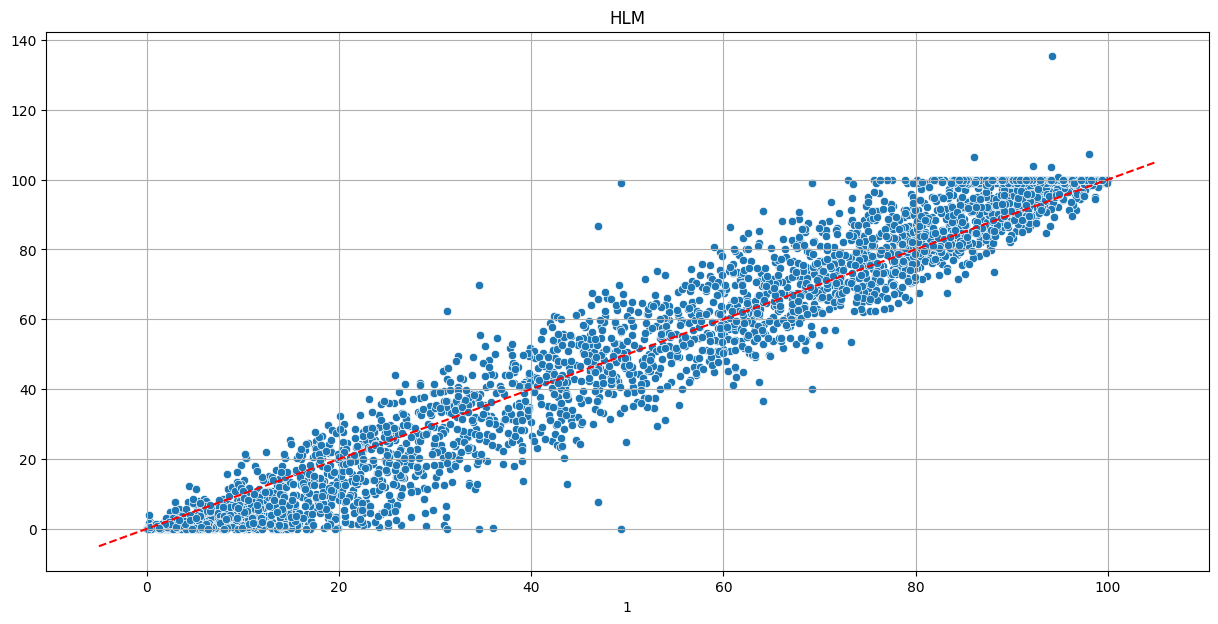

In [118]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,0],y=y_new[:,0])
abline(0,1)
plt.grid()
plt.title('MLM')
plt.show()

plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,1],y=y_new[:,1])
abline(0,1)
plt.grid()
plt.title('HLM')
plt.show()

In [119]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred

In [120]:
submit.head()

,id,MLM,HLM
0,TEST_000,16.853423,32.840609
1,TEST_001,63.515890,84.250384
2,TEST_002,57.868589,75.193658
3,TEST_003,54.650181,72.973424
4,TEST_004,70.817628,82.852778


In [121]:
# public : 30.1133550656 (identity)
submit.to_csv('./out/25_stacking_new_chemical_data.csv',index=False)